# **Welcome to Mario Alcaraz Scraping Bot Data Analysis 🏠**


# Dataset creation

In [53]:
import pandas as pd
import numpy as np
import re

allProvincias = ['A-Coruna', 'Araba-alava', 'Albacete', 'Alicante', 'Almeria', 'Asturias', 'Avila', 'Badajoz', 'Barcelona', 'Burgos', 'Caceres',
                 'Cadiz', 'Cantabria', 'Castellon', 'Ciudad-Real', 'Cordoba', 'Cuenca', 'Girona', 'Granada', 'Guadalajara',
                 'Gipuzkoa', 'Huelva', 'Huesca', 'Illes-balears', 'Jaen', 'Leon', 'Lleida', 'Madrid', 'Malaga', 'Murcia', 'Navarra',
                 'Ourense', 'Palencia', 'Las-Palmas', 'Pontevedra', 'La-Rioja', 'Lugo', 'Salamanca', 'Segovia', 'Sevilla', 'Soria', 'Tarragona',
                 'Santa-Cruz-de-Tenerife', 'Teruel', 'Toledo', 'Valencia', 'Valladolid', 'Bizkaia', 'Zamora', 'Zaragoza']

## Create a dataset called Spain with all the data from the datasets of all provinces ##
Spain = pd.DataFrame()

for i in allProvincias:
  file = open('/content/drive/MyDrive/datasets/' + i + '-dataset.csv')
  data = pd.read_csv(file, engine='python',on_bad_lines='skip')
  #Add Province name
  data['Province'] = i
  Spain = pd.concat([Spain, data], axis=0)

Spain.to_csv('/content/drive/MyDrive/datasets/Spain-dataset.csv', index=False)

In [54]:
## Transform data into the correct type ##

Spain[['Price', 'Price change', 'Rooms', 'Bathrooms', 'Squares', 'Floor']] = Spain[['Price', 'Price change', 'Rooms', 'Bathrooms', 'Squares', 'Floor']].apply(lambda x: pd.to_numeric(x, errors='coerce'))
Spain[['Link','Title', 'Description', 'Type','Antiquity','Orientation','Heating','Hot water','Condition state', 'Furnished', 'Consumption','Emitions', 'Parking','Ubication','Floor.1','Province']] = Spain[['Link','Title', 'Description', 'Type','Antiquity','Orientation','Heating','Hot water','Condition state', 'Furnished', 'Consumption','Emitions', 'Parking','Ubication', 'Floor.1','Province']].astype('string')
Spain['Parking'] = Spain['Parking'].map({'Comunitario': True, 'N/A parking': False, 'Privado': True}).astype(bool)
Spain['Elevator'] = Spain['Elevator'].map({'Sí': True, 'N/A elevator': False}).astype(bool)

Spain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 507309 entries, 0 to 6431
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Link             506026 non-null  string 
 1   Title            495745 non-null  string 
 2   Price            491770 non-null  float64
 3   Price change     506022 non-null  float64
 4   Rooms            447629 non-null  float64
 5   Bathrooms        419965 non-null  float64
 6   Squares          488086 non-null  float64
 7   Floor            217270 non-null  float64
 8   Description      483199 non-null  string 
 9   Type             489972 non-null  string 
 10  Antiquity        489972 non-null  string 
 11  Orientation      489972 non-null  string 
 12  Heating          489972 non-null  string 
 13  Hot water        489972 non-null  string 
 14  Condition state  489972 non-null  string 
 15  Floor.1          489972 non-null  string 
 16  Elevator         507309 non-null  bool  

# Filling missing data

In [55]:
## If there is no information about bathroom, and rooms, then is 1 as there was a mistake scraping data ##
Spain['Bathrooms'] = Spain['Bathrooms'].fillna(1.0)
Spain['Rooms'] = Spain['Rooms'].fillna(1.0)
## Announces that have 'Parking' field empty but the word "garaje" or "parking" appear we put it as true ##
Spain.loc[(Spain['Description'].str.contains('garaje|parking', case=False)) & (Spain['Parking'] == False), 'Parking'] = True

## Create a new column called 'Swimming_pool' with boolean values ##
Spain['Swimming_pool'] = Spain['Description'].str.contains('piscina', case=False)
Spain['Swimming_pool'] = Spain['Swimming_pool'].fillna(False)
Spain['Swimming_pool'] = Spain['Swimming_pool'].astype(bool)

## Adding missing values as "N/A in certain columns"
Spain['Title'].fillna("N/A", inplace=True)
Spain['Description'].fillna("N/A", inplace=True)
Spain['Ubication'].fillna("N/A", inplace=True)

## As we have Floor and Floor.1 we can obtain more information from by mixing the data
Spain['Floor'] = Spain.apply(lambda row: 0 if ('Bajos' in str(row['Floor.1'])) or ('Entresuelo' in str(row['Floor.1'])) or ('Principal' in str(row['Floor.1'])) else row['Floor'], axis=1) # This can be considered as floor level so -> 0
Spain['Floor'] = Spain.apply(lambda row: -1 if ('Sótano' in str(row['Floor.1'])) or ('Subsótano' in str(row['Floor.1'])) else row['Floor'], axis=1) # This can be considered under floor level so -> -1 (Less natural light than 0 or +1).
# We can do the same usinng Type. This increase Floor adding +150.000 values
Spain['Floor'] = Spain.apply(lambda row: 0 if ('Planta baja' in str(row['Type'])) or ('Casa o chalet' in str(row['Type'])) or ('Casa adosada' in str(row['Type'])) or ('Finca rústica' in str(row['Type'])) else row['Floor'], axis=1) # This can be considered as floor level so -> 0


In [56]:
## We have to remove all rows containing 'N/A' Link and all the null values in Link ##
Spain = Spain[~Spain['Link'].str.contains('N/A', case=False)]
Spain.dropna(subset=['Link'], inplace=True)

# Add City name extracted from the announcement link
city_pattern = re.compile(r'/vivienda/([^/]+)')
Spain['City'] = Spain['Link'].apply(lambda link: city_pattern.search(link).group(1).replace('-',' ').title() if city_pattern.search(link) else None)
Spain['City'] = Spain['City'].astype('string')

# Cleaning data

In [57]:
## Drop duplicates ##
Spain = Spain.drop_duplicates(subset=Spain.columns.tolist())
Spain = Spain.drop_duplicates('Link')
#Spain.info()

In [58]:
## Remove all rows containing 'N/A' Link and all the null values in Link ##
Spain = Spain[~Spain['Link'].str.contains('N/A', case=False)]
Spain.dropna(subset=['Link'], inplace=True)

if (Spain['Link'].str.contains('N/A', case=False).sum() == 0 and Spain['Link'].isna().sum() == 0):
  print("Invalid links cleaned!")
else:
  print("Error cleaning links")

## Delete houses under 1000 euros as this can not be consider as a valid one ##
Spain = Spain[Spain['Price'] > 1000]
val = (Spain['Price'] < 1000).sum()
if(val > 0):
  print(f'There is {val} rows where price is lower than 1000.')    
else :
    print("Invalid houses cleaned!")

## Delete houses with extreme prices as this can not be consider as a valid one ##
Spain = Spain[Spain['Price'] < 19900000] # 19.9M as maximum 
val = (Spain['Price'] > 19900000).sum()
if(val > 0):
  print(f'There is {val} rows where price is extreme.')    
else :
    print("Invalid houses cleaned!")

## Delete houses with extreme number of rooms ##
Spain = Spain[Spain['Rooms'] < 70]
val = (Spain['Rooms'] > 70).sum()
if(val > 0):
    print(f'There is {val} rows whit more than 70 rooms.')    
else :
    print("Invalid rooms cleaned!")

## Delete houses with extreme number of bathrooms ##
Spain = Spain[Spain['Bathrooms'] < 50]
val = (Spain['Bathrooms'] > 50).sum()
if(val > 0):
    print(f'There is {val} rows whit more than 50 bathrooms.')    
else :
    print("Invalid bathrooms cleaned!")

## Delete houses with extreme number of square meters ##
Spain = Spain[ (Spain['Squares'] >= 10) & (Spain['Squares'] < 10000)]
val = (Spain['Squares'] > 10000).sum() + (Spain['Squares'] < 10).sum()
if(val > 0):
    print(f'There is {val} rows whit more than 20000 squares, or less than 10')    
else :
    print("Invalid squares cleaned!")

#Spain.info()

Invalid links cleaned!
Invalid houses cleaned!
Invalid houses cleaned!
Invalid rooms cleaned!
Invalid bathrooms cleaned!
Invalid squares cleaned!


In [59]:
Spain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328462 entries, 0 to 6424
Data columns (total 25 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Link             328462 non-null  string 
 1   Title            328462 non-null  string 
 2   Price            328462 non-null  float64
 3   Price change     328462 non-null  float64
 4   Rooms            328462 non-null  float64
 5   Bathrooms        328462 non-null  float64
 6   Squares          328462 non-null  float64
 7   Floor            260283 non-null  float64
 8   Description      328462 non-null  string 
 9   Type             328462 non-null  string 
 10  Antiquity        328462 non-null  string 
 11  Orientation      328462 non-null  string 
 12  Heating          328462 non-null  string 
 13  Hot water        328462 non-null  string 
 14  Condition state  328462 non-null  string 
 15  Floor.1          328462 non-null  string 
 16  Elevator         328462 non-null  bool  

# Data analysis approach

In [60]:
totalCount = Spain['Link'].count() / 100
# Iterate through all columns in the data dataframe
for col in Spain.columns:
    
    # For numeric columns
    col_pct  = round(Spain[col].count() / totalCount, 3) # Percentage of non-null obj
    
    # For string colums
    if Spain[col].dtype == 'string':
      na_count = Spain[col].str.contains("N/A", case=False).sum()
      na_pct   = round(na_count / totalCount, 3) # Percentage of N/A fields      

    #if col_pct < 99.99:
        #print ("======")
        #print(f"{col} has {100 - col_pct} % empty values.")
    #if na_pct > 30:
        #print ("======")
        #print(f"{col} has {na_pct} % N/A values.")

In [61]:
## Very simple analysis ##
pd.set_option('float_format', '{:.2f}'.format)
Spain.describe()

Price  Price change     Rooms  Bathrooms   Squares     Floor
count   328462.00     328462.00 328462.00  328462.00 328462.00 260283.00
mean    231750.14      -4996.10      3.14       1.85    163.43      1.39
std     400597.05      28646.28      1.45       1.06    293.25      1.90
min       1500.00   -3900000.00      1.00       1.00     10.00     -1.00
25%      89000.00          0.00      2.00       1.00     80.00      0.00
50%     145000.00          0.00      3.00       2.00    108.00      1.00
75%     249000.00          0.00      4.00       2.00    168.00      2.00
max   17000000.00          0.00     55.00      45.00   9991.00     15.00

In [62]:
## Brief analysis about some variables in the dataset ##
totalCount = Spain['Link'].count() / 100

## Percentage of houses with swimming pools
swimming_pool_yes = (Spain['Swimming_pool']==1).sum()
pct_swimming = round(swimming_pool_yes/totalCount, 2)

## Percentage of houses with parking
parking_yes = (Spain['Parking']==1).sum()
pct_parking = round(parking_yes/totalCount, 2)

## Percentage of houses with elevator
elevator_yes = (Spain['Elevator']==1).sum()
pct_elevator = round(elevator_yes/totalCount, 2)


print(f"The percentage of houses with swimming pool is {pct_swimming} %")
print(f"The percentage of houses with parking is {pct_parking} %")
print(f"The percentage of houses with elevator is {pct_elevator} %")

# Mean percentage change when a house change its price.
Spain_filtered = Spain[Spain['Price change'] < 0]
pct_change = round((((Spain_filtered['Price change']) / Spain_filtered['Price']) * 100).mean(),5)
print(f"When houses price change, the mean is {pct_change}%")
print(f"The percentage of houses on sale that drop their price is {Spain_filtered['Link'].count() / totalCount}%")


The percentage of houses with swimming pool is 19.15 %
The percentage of houses with parking is 48.78 %
The percentage of houses with elevator is 38.73 %
When houses price change, the mean is -12.36445%
The percentage of houses on sale that drop their price is 23.002660886190792%


In [63]:
from tabulate import tabulate

# Removing outliers for this calculations
## Here we obtain the mean price per announcement in a province
price_per_province = Spain.groupby('Province').apply(lambda x: np.mean(np.sort(x['Price']))).round(2)
## Here we obtain the mean price per square in an announcement and the mean of them
price_m2_per_province_trimmed = Spain.groupby('Province').apply(lambda x: np.mean(np.sort(x['Price'] / x['Squares']))).round(2)

# Quick analysis aggrupated by Provinces. This is represented as a map with different colours in the documentation of the project.
provinces = Spain['Province'].unique()
table = []
for province in sorted(provinces):
  table.append([province, price_per_province[province], price_m2_per_province_trimmed[province] ])

print(tabulate(table, headers=['Province', 'Mean price per announcement', 'Mean price per square per announcement']))

Province                  Mean price per announcement    Mean price per square per announcement
----------------------  -----------------------------  ----------------------------------------
A-Coruna                                       179611                                   1383.97
Albacete                                       150395                                   1098.95
Alicante                                       328947                                   2030.34
Almeria                                        141135                                   1255.41
Araba-alava                                    272140                                   2406.6
Asturias                                       152663                                   1375.91
Avila                                          123364                                    856.62
Badajoz                                        138025                                   1010.14
Barcelona                                

# Data analysis representation

In [64]:
import sys
!{sys.executable} -m pip install sweetviz

import sweetviz as sv

## Once dataset is cleaned, with this we get an auto-generated analysis with valuable information.
my_report = sv.analyze(Spain)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.m


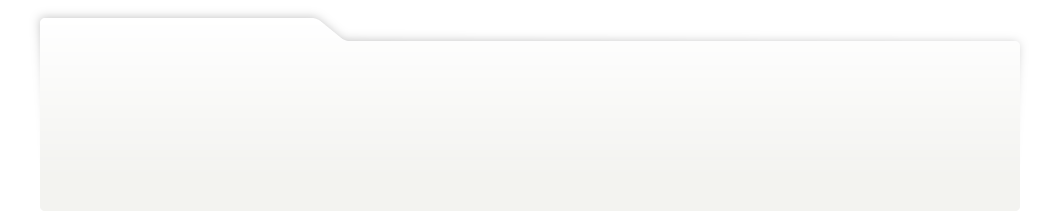
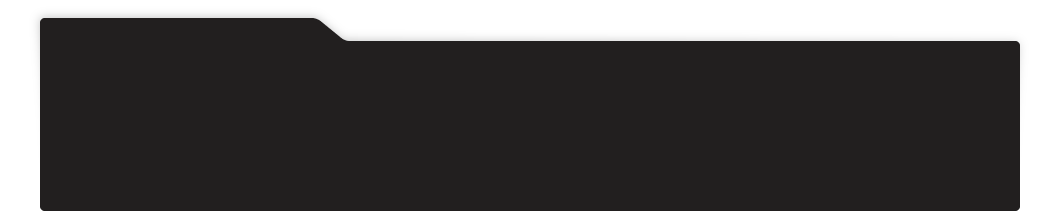
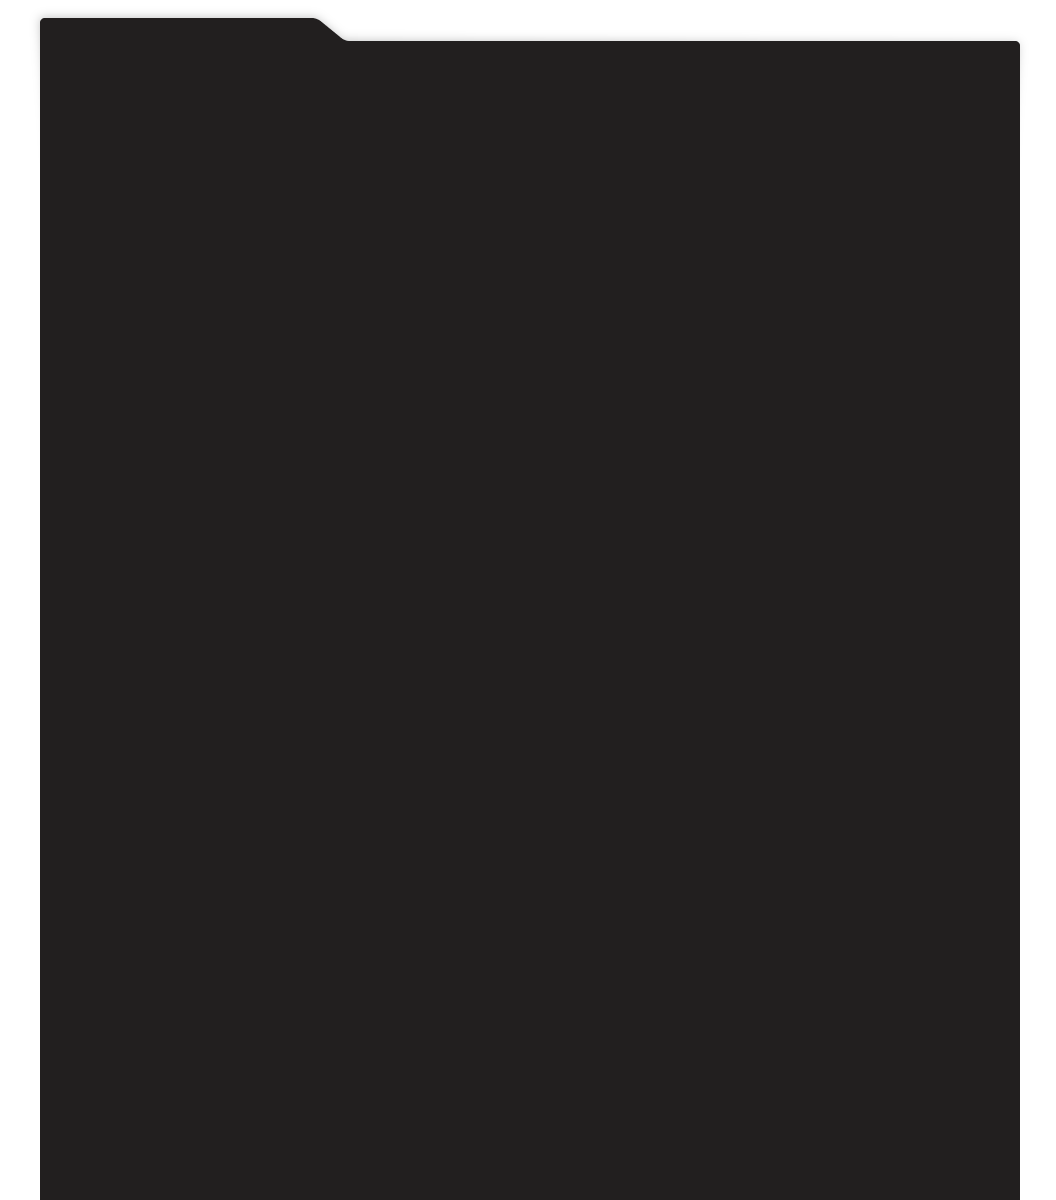
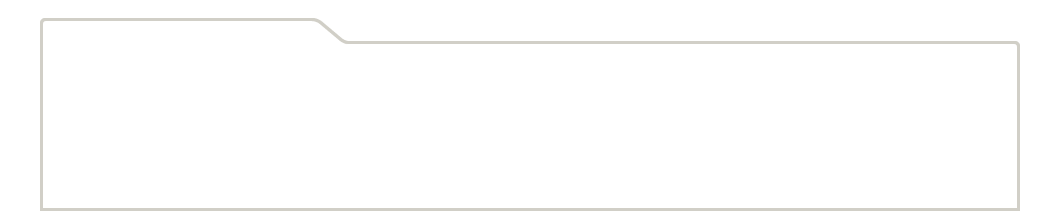
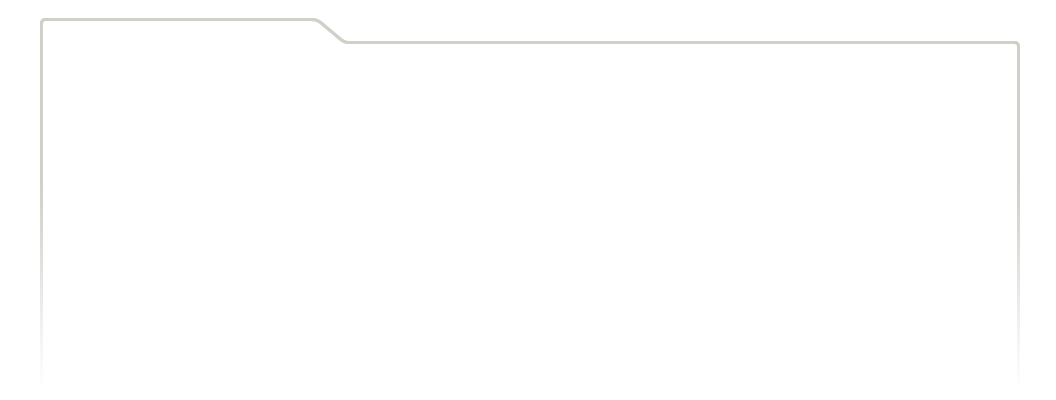
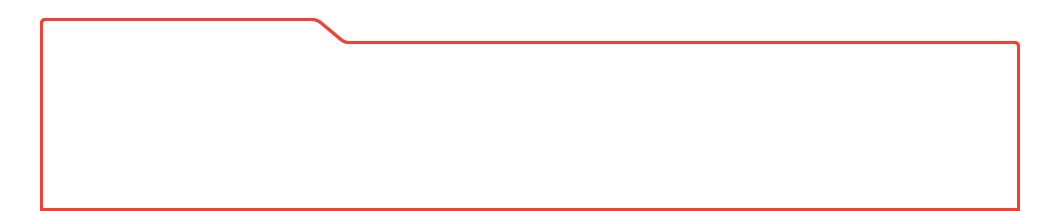
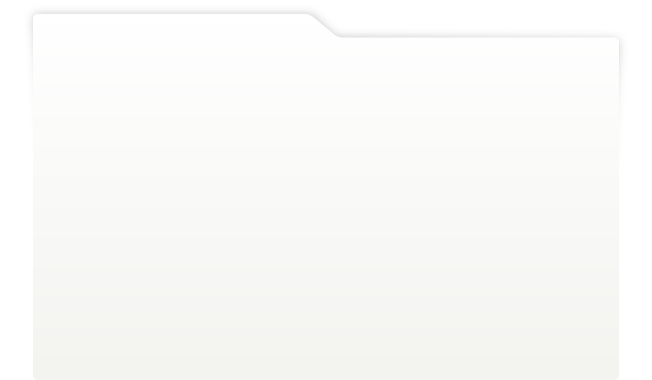
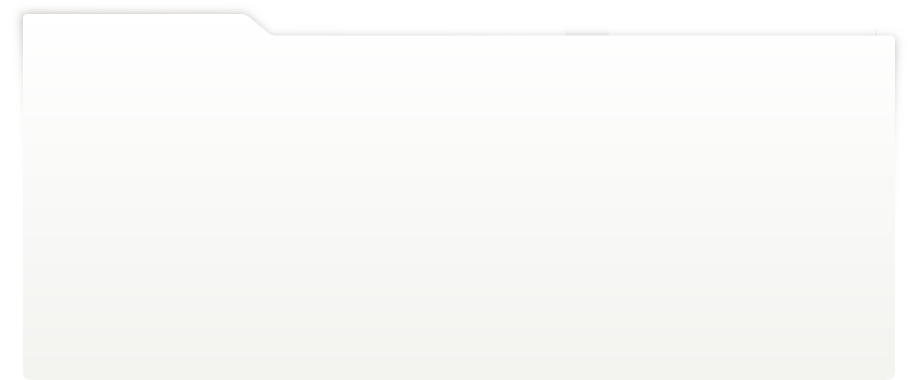
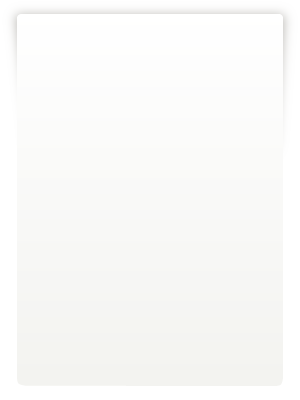
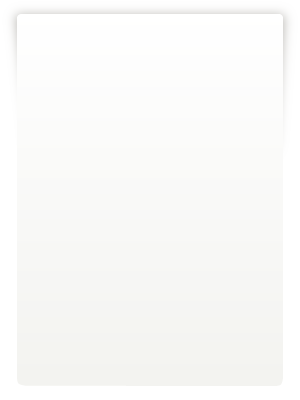
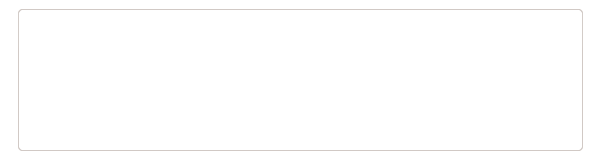
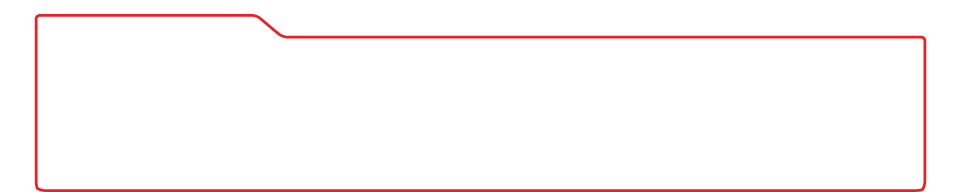
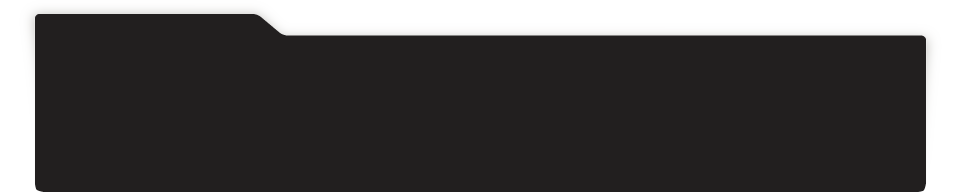
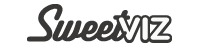
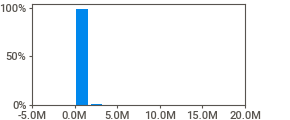
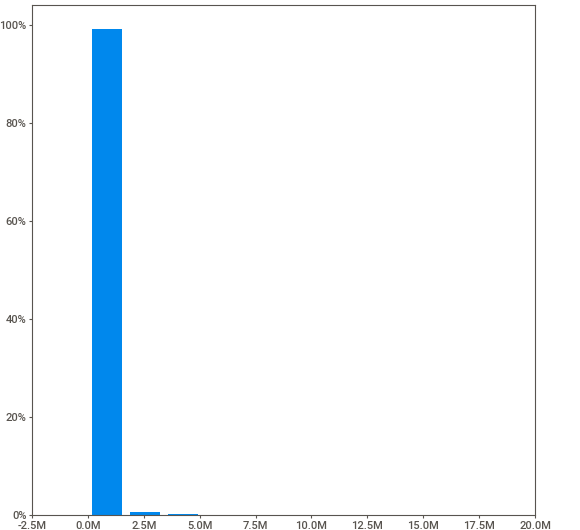
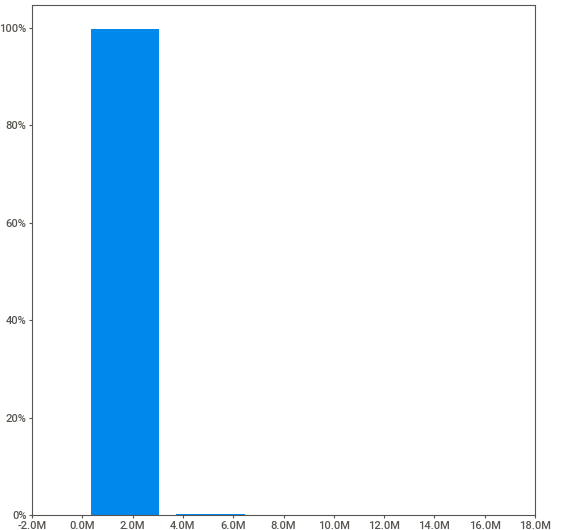
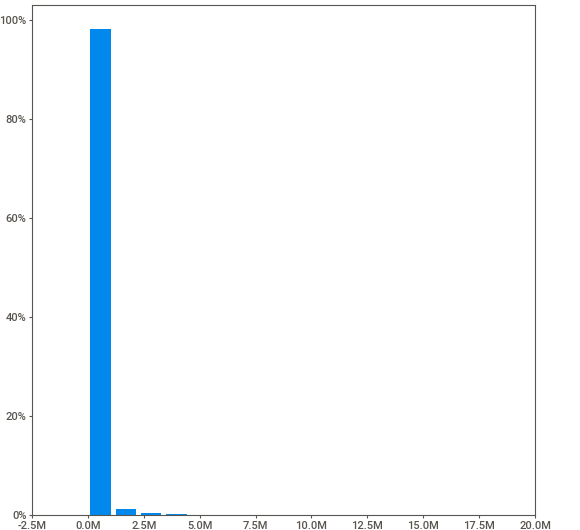
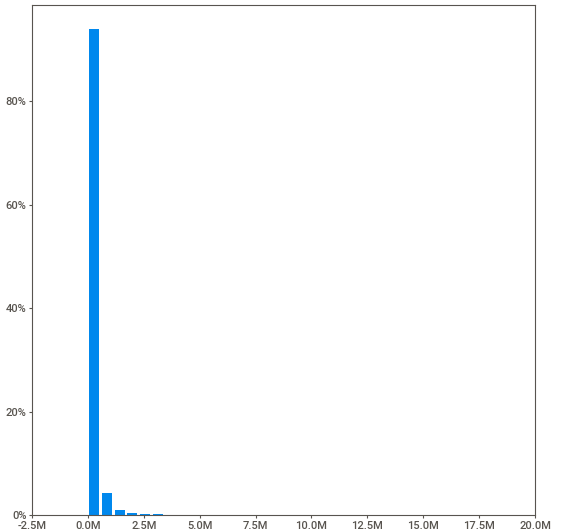
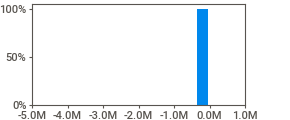
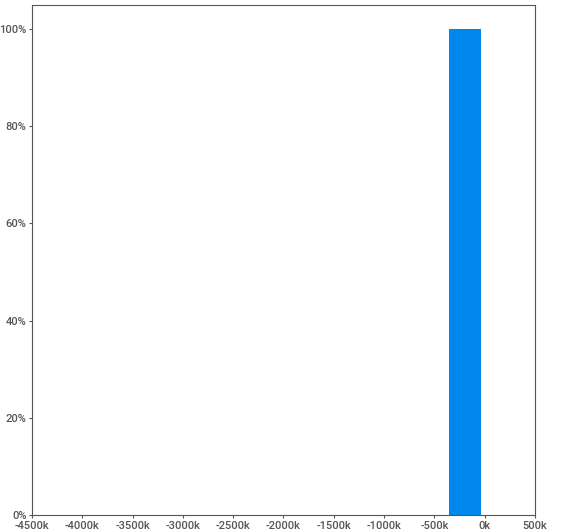
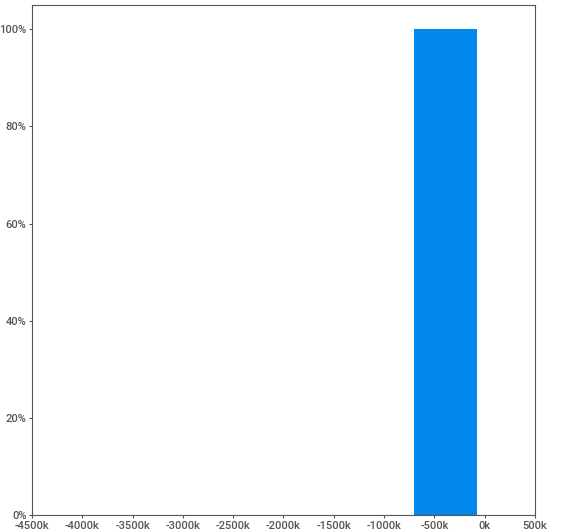
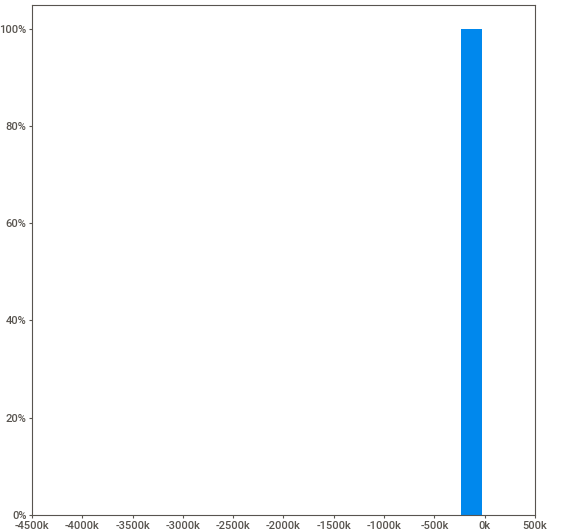
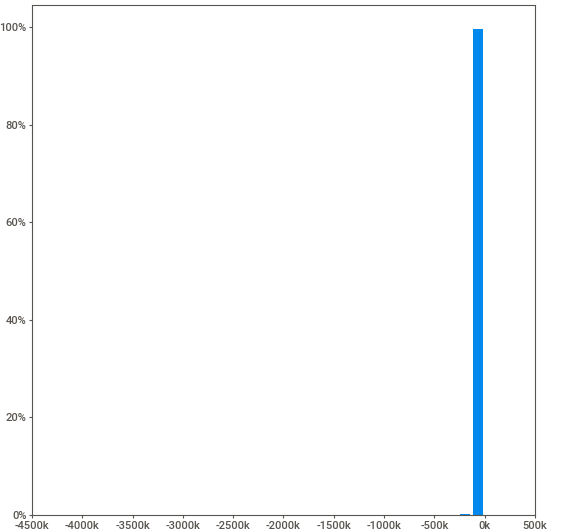
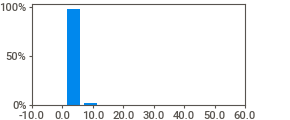
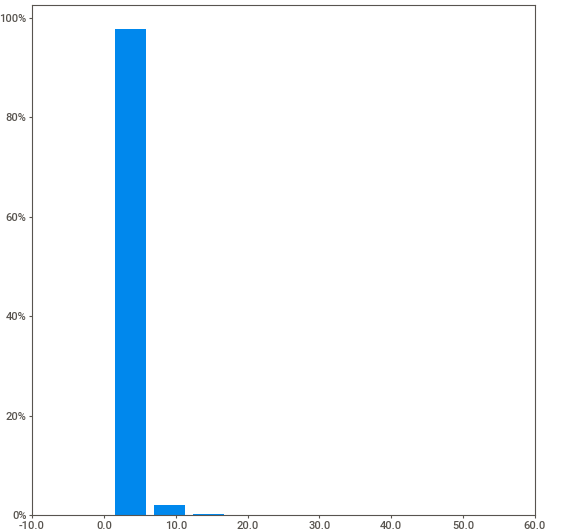
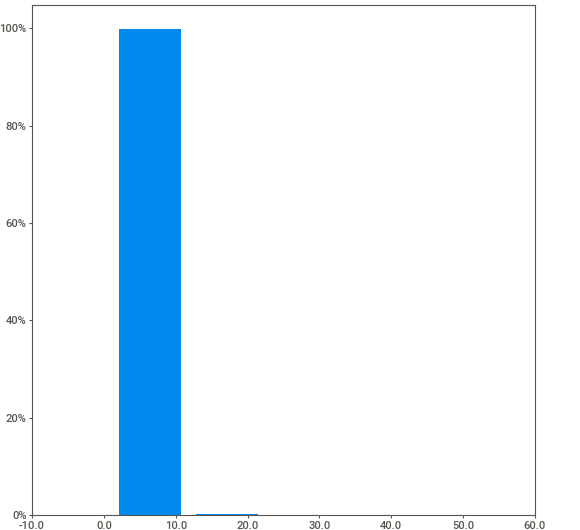
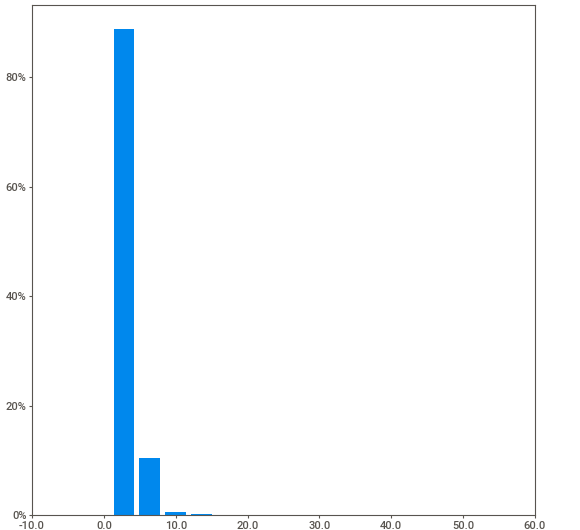
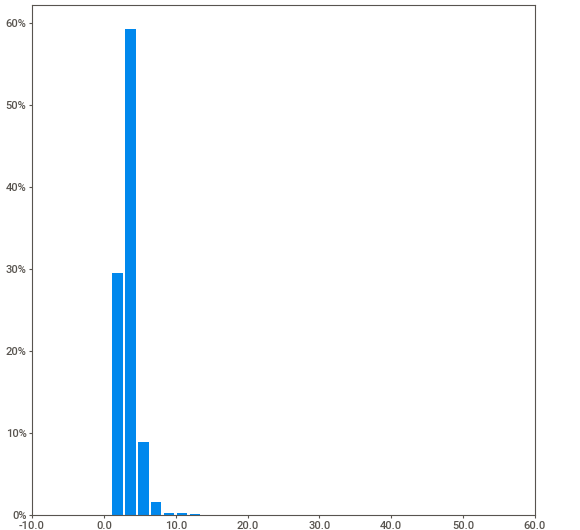
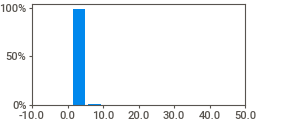
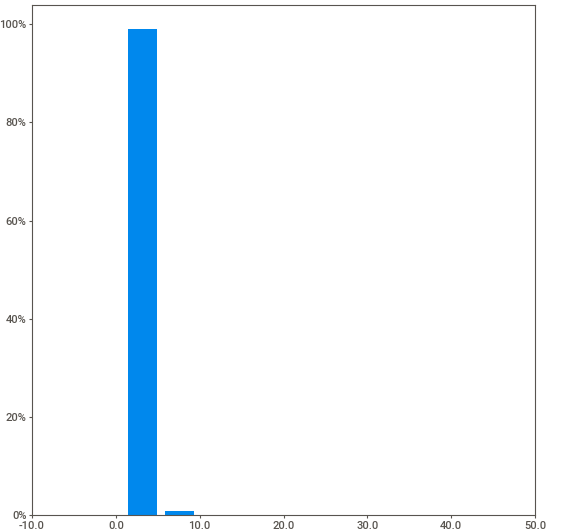
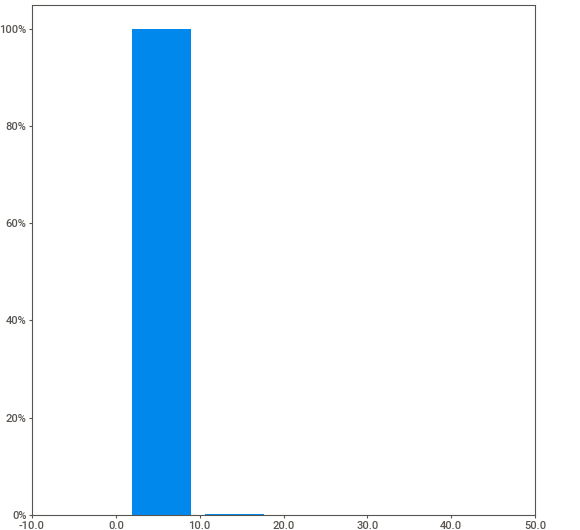
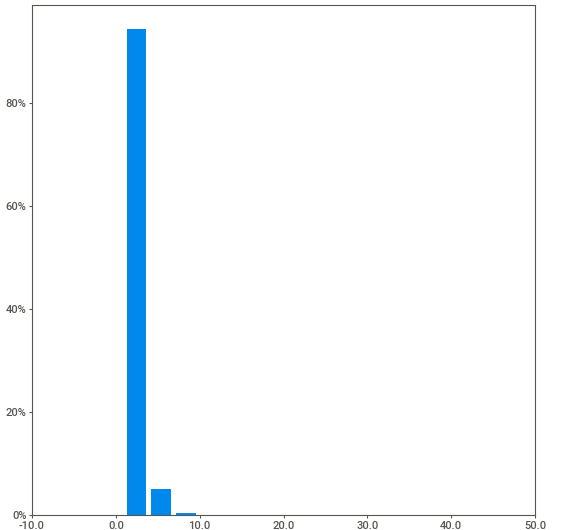
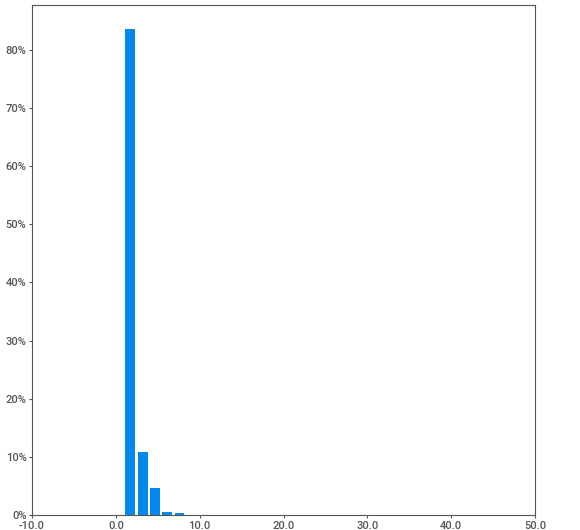
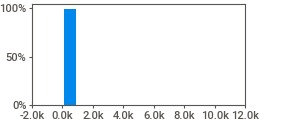
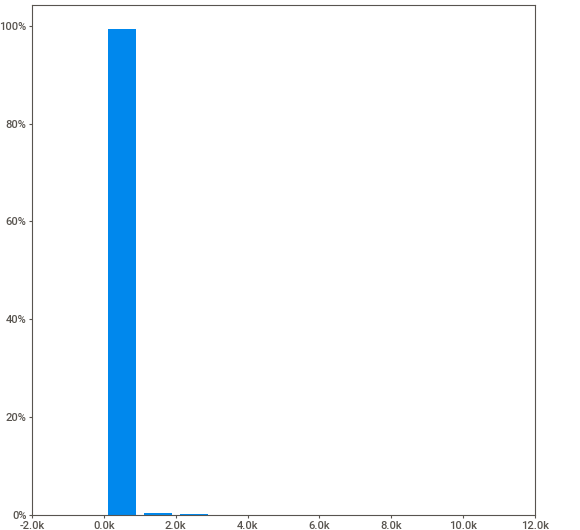
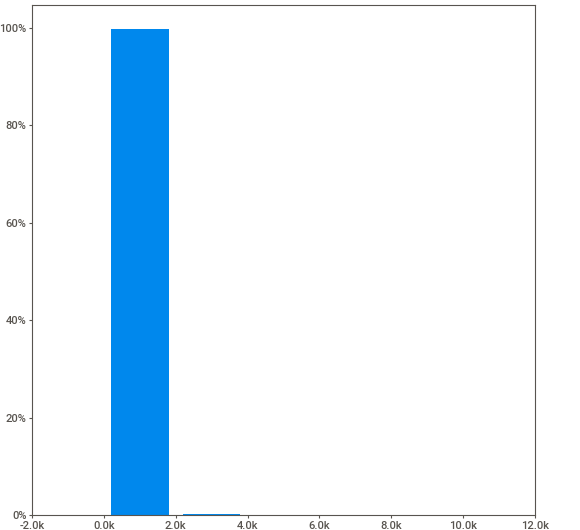
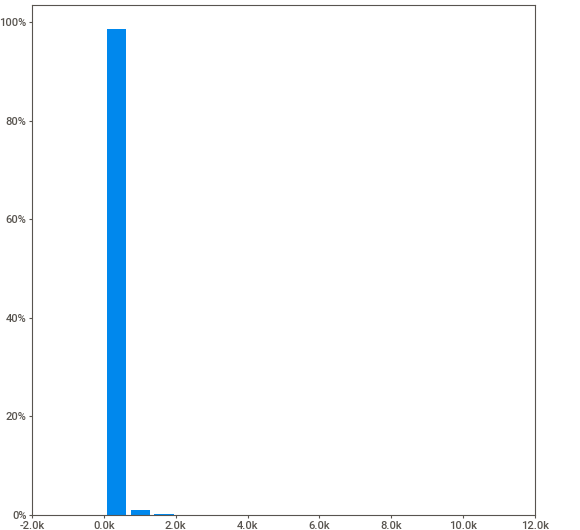
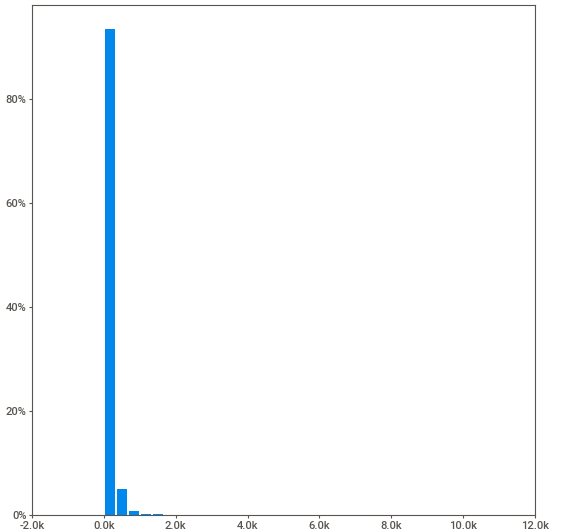
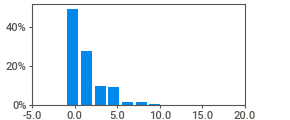
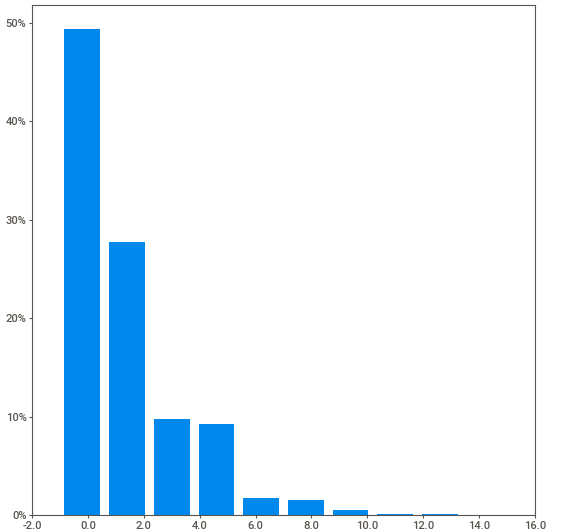
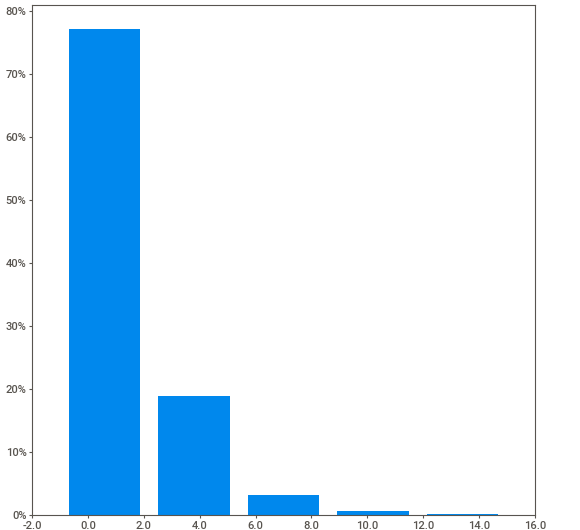
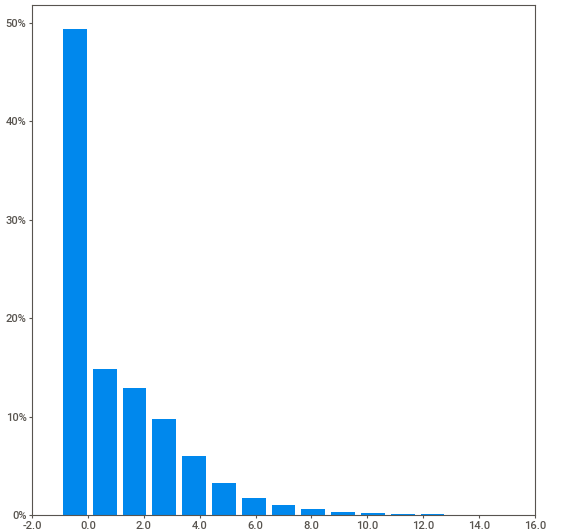
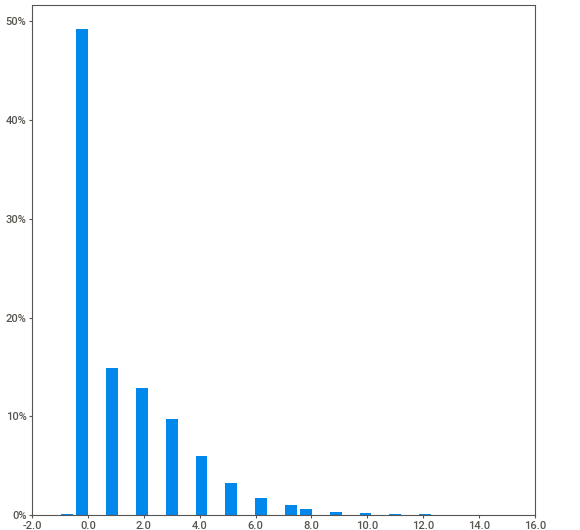
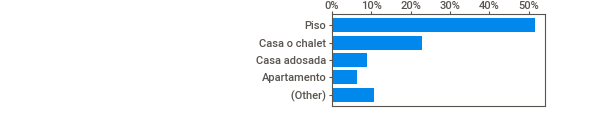
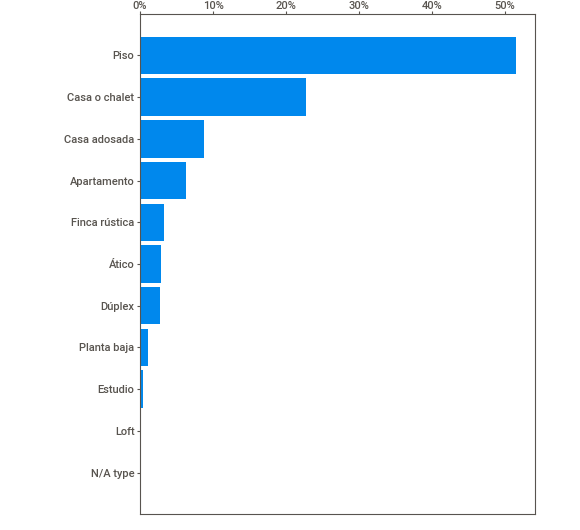
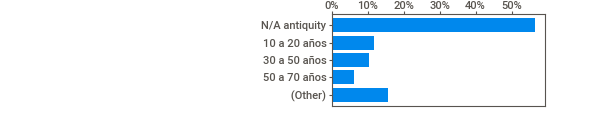
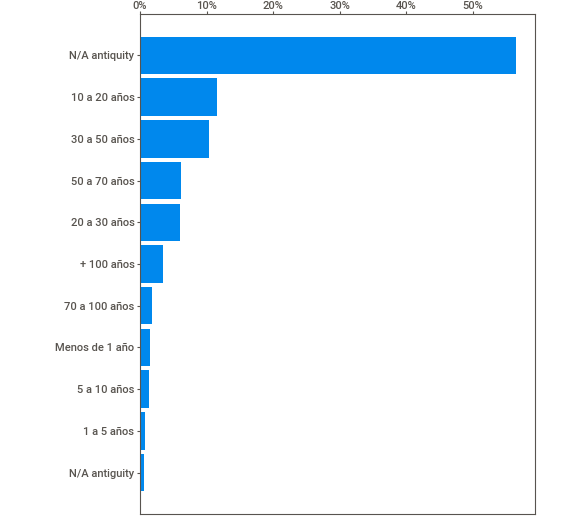
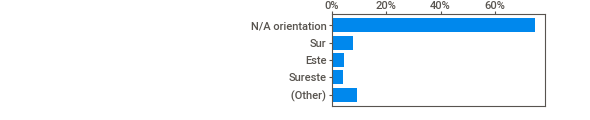
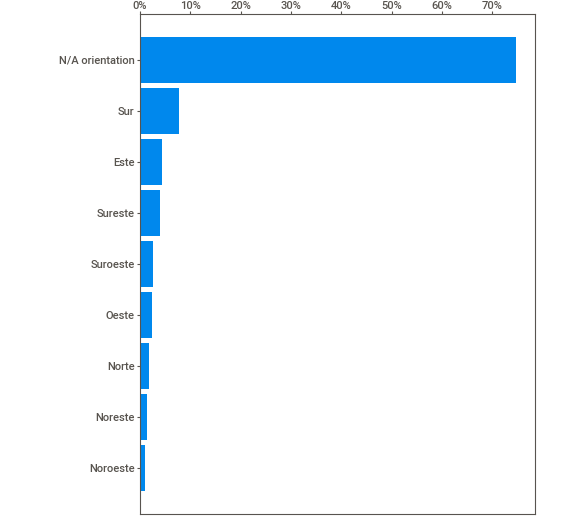
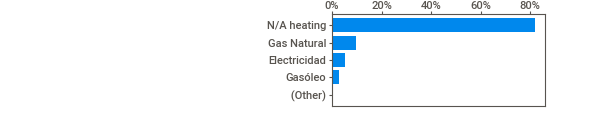
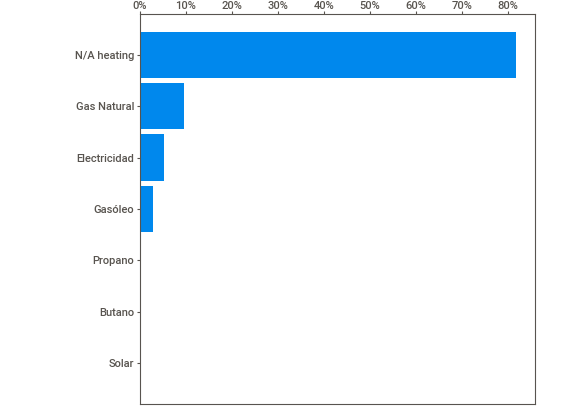
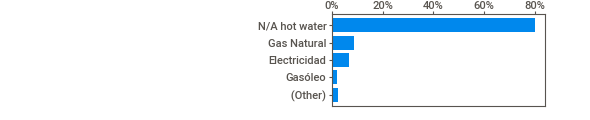
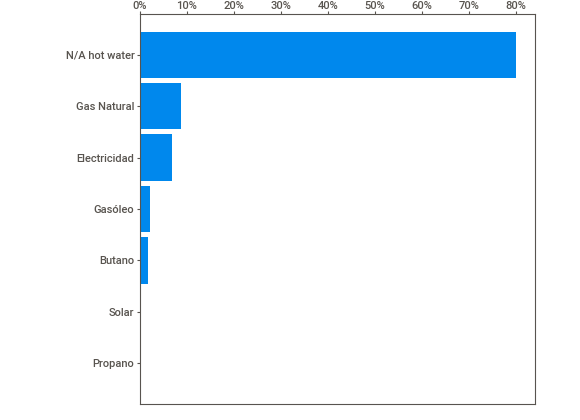
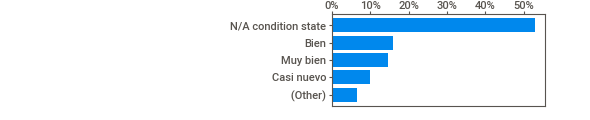
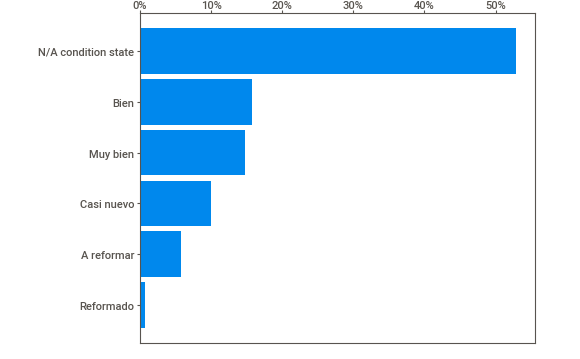
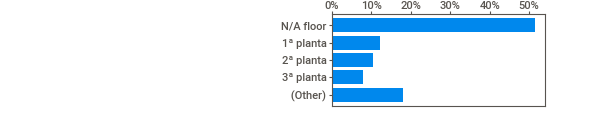
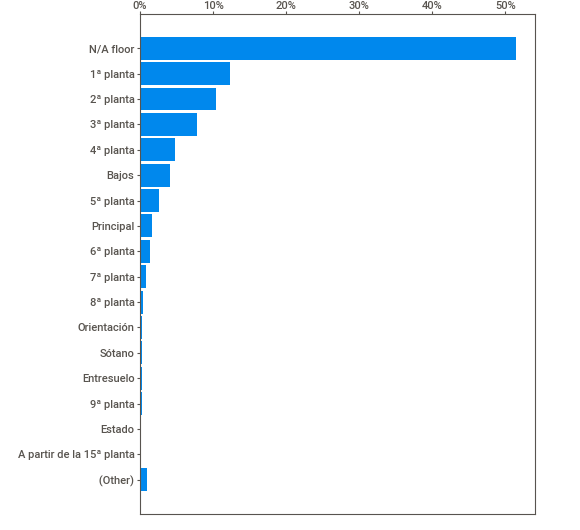
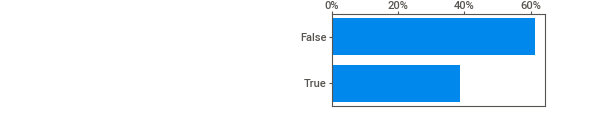
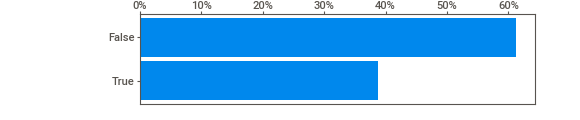
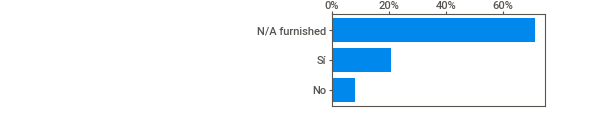
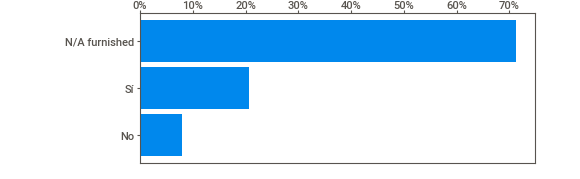
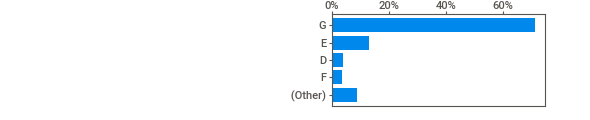
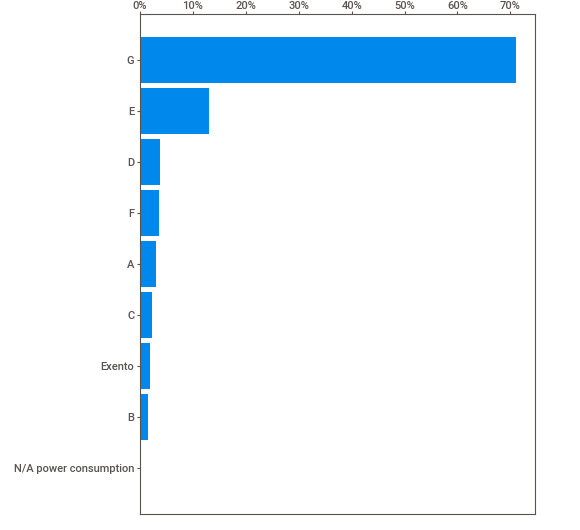
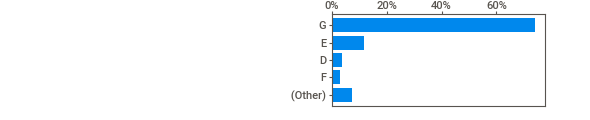
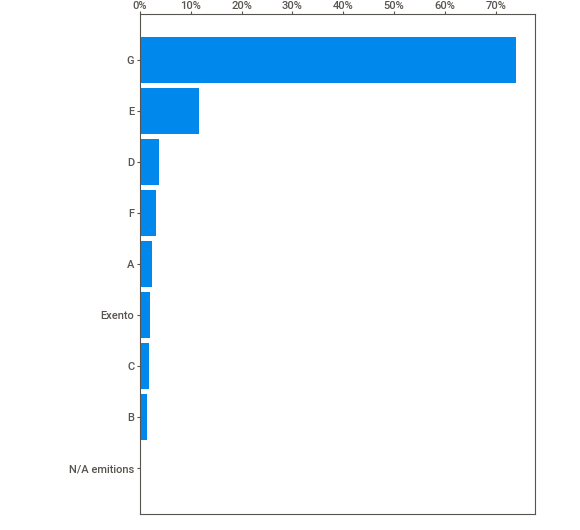
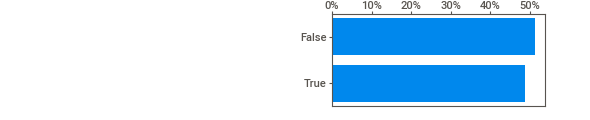
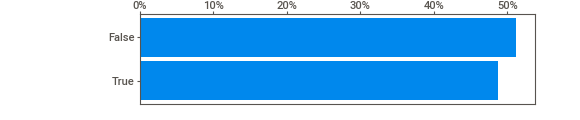
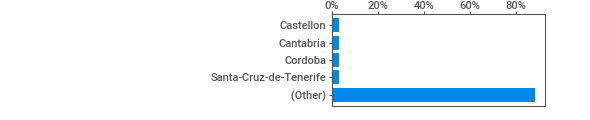
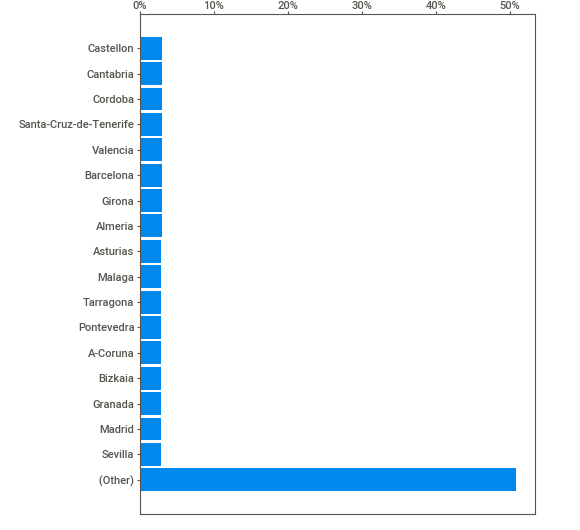
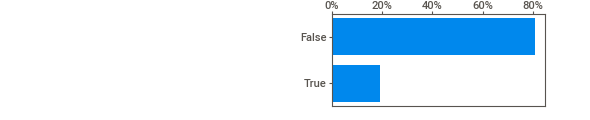
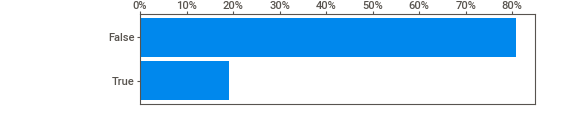
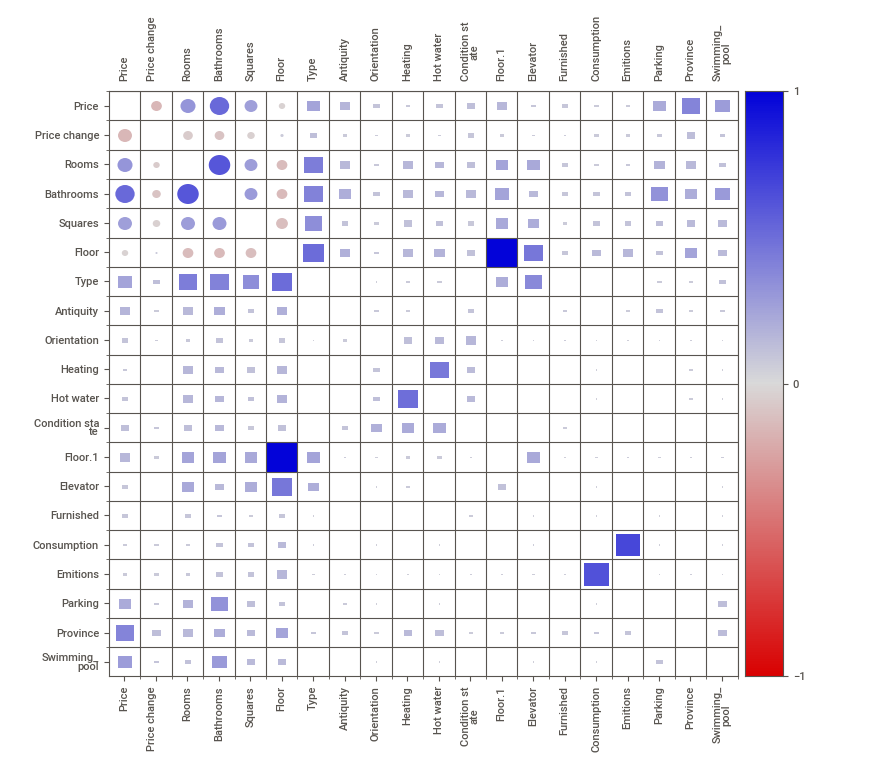
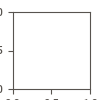

In [65]:
## Visualize some results. Nice graphs will be generated later with other programs and tools.
my_report.show_notebook()

**Graphical representation**

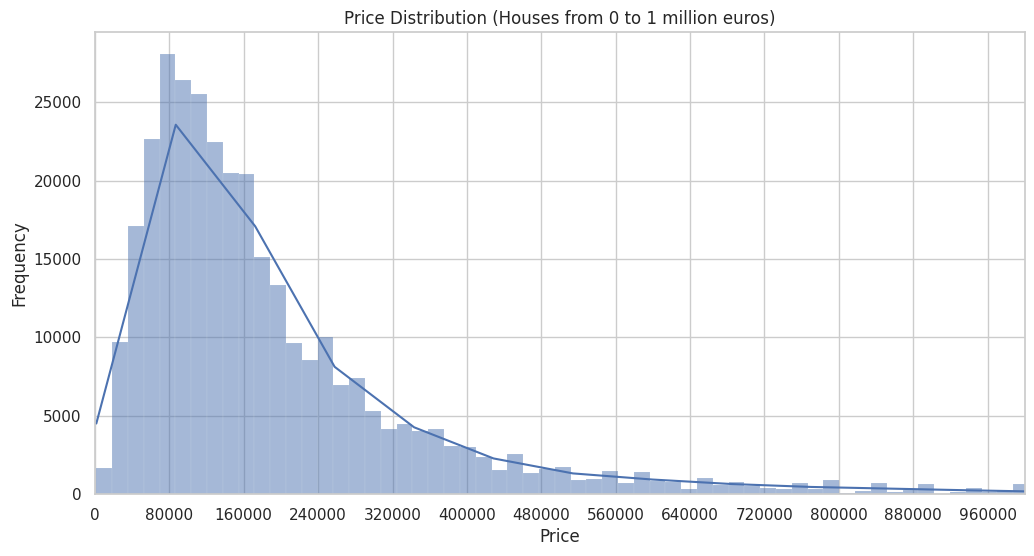

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set the style for the Seaborn plot
sns.set(style='whitegrid')

# Create a histogram of the 'price' column with a custom range
plt.figure(figsize=(12, 6))
sns.histplot(Spain, x='Price', bins=1000, kde=True)

# Set the x-axis range from 0 to 1 million
plt.xlim(-50, 1000000)

# Set the labels and title
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution (Houses from 0 to 1 million euros)')

# Set the number of X axis numbers
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=16))

# Save the plot as an image file
plt.savefig('price_histogram.png')

# Show the plot
plt.show()

In [67]:
median = Spain['Price'].median()
print("Median:", median)

# Calculate the 25th and 75th percentiles
q25 = Spain['Price'].quantile(0.25)
q75 = Spain['Price'].quantile(0.75)

# Get the values at the 25th and 75th percentiles
value_at_25 = Spain.loc[Spain['Price'] == q25, 'Price'].values[0]
value_at_75 = Spain.loc[Spain['Price'] == q75, 'Price'].values[0]

print("Value at 25th percentile:", value_at_25)
print("Value at 75th percentile:", value_at_75)

Median: 145000.0
Value at 25th percentile: 89000.0
Value at 75th percentile: 249000.0


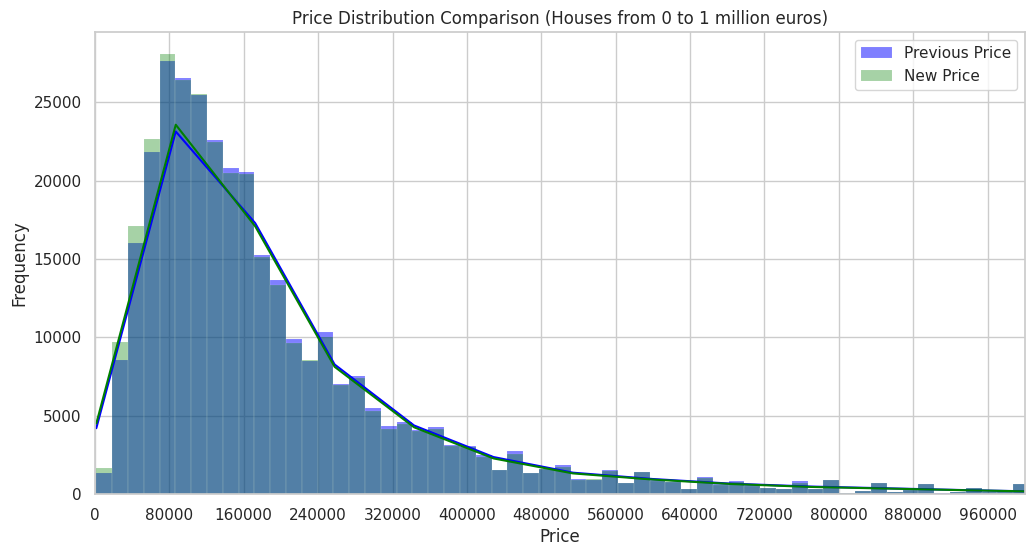

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Create a copy of the Spain dataset
Spain_copy = Spain.copy()

# Create a temporary column for the previous price
Spain_copy['Previous Price'] = Spain_copy['Price'] - Spain_copy['Price change']

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(12,6))

# Plot the previous price distribution with a blue color and label
sns.histplot(Spain_copy, x='Previous Price', bins=1000, kde=True, ax=ax, color='blue', alpha=0.5, label='Previous Price')

# Plot the new price distribution with an orange color and label
sns.histplot(Spain_copy, x='Price', bins=1000, kde=True, ax=ax, color='green', alpha=0.35, label='New Price')

# Set the x-axis range from 0 to 1 million
ax.set_xlim(-50, 1000000)

# Set the labels and title
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.set_title('Price Distribution Comparison (Houses from 0 to 1 million euros)')

# Set the number of X axis numbers
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=16))

# Add a legend
ax.legend()

# Save the plot as an image file
plt.savefig('price_comparison.png')

# Show the plot
plt.show()


1418.0342915058827


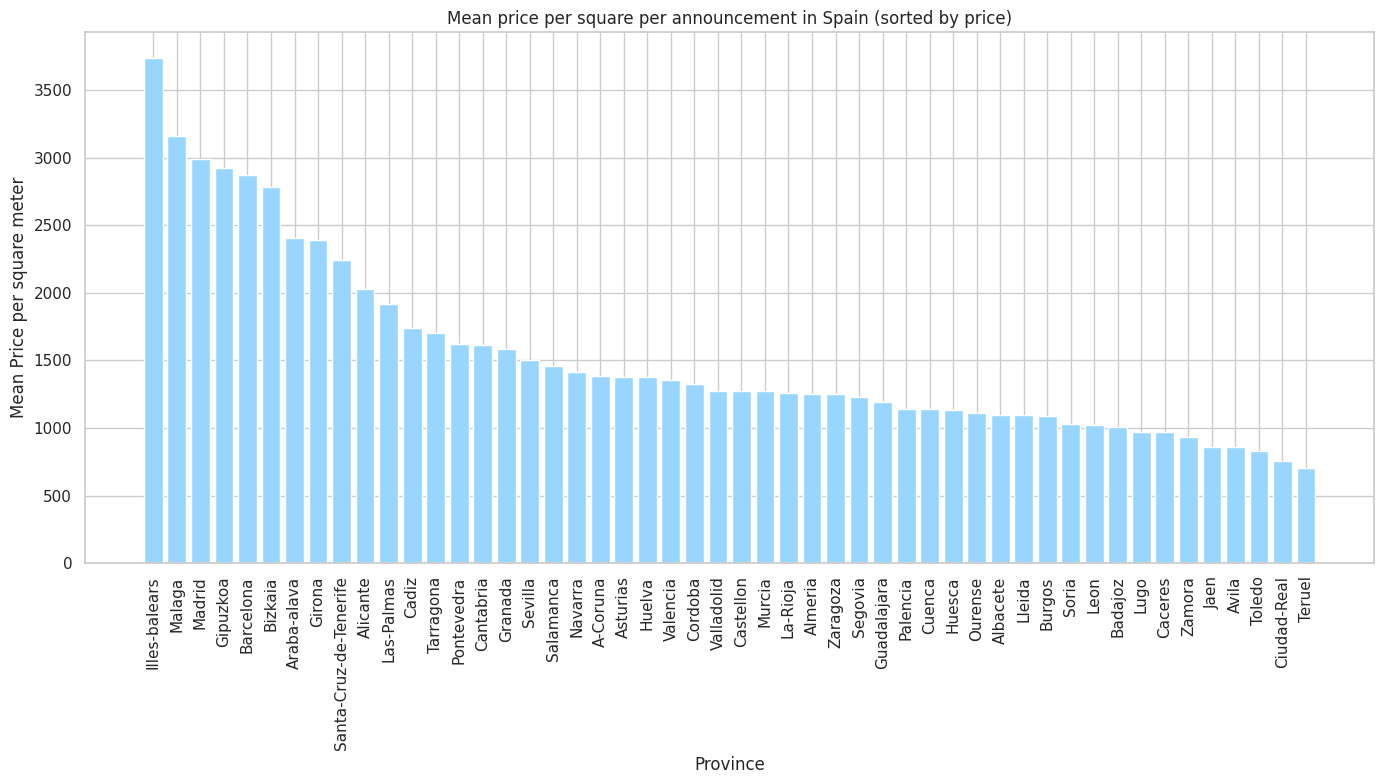

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the mean price per square meter for the whole dataset
mean_price_per_sqm = Spain['Price'].mean() / Spain['Squares'].mean()
# Display the overall mean price per square meter
print(mean_price_per_sqm)

# Sort the data in descending order
price_per_province_sorted = price_m2_per_province_trimmed.sort_values(ascending=False)

# Create a vertical bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x_pos = np.arange(len(price_per_province_sorted.index))
ax.bar(x_pos, price_per_province_sorted.values, align='center', color='#99d6ff')
ax.set_xticks(x_pos)
ax.set_xticklabels(price_per_province_sorted.index, rotation=90)
ax.set_xlabel('Province')
ax.set_ylabel('Mean Price per square meter')
ax.set_title('Mean price per square per announcement in Spain (sorted by price)')
plt.tight_layout()
plt.savefig('province_price_squares_meters.png')

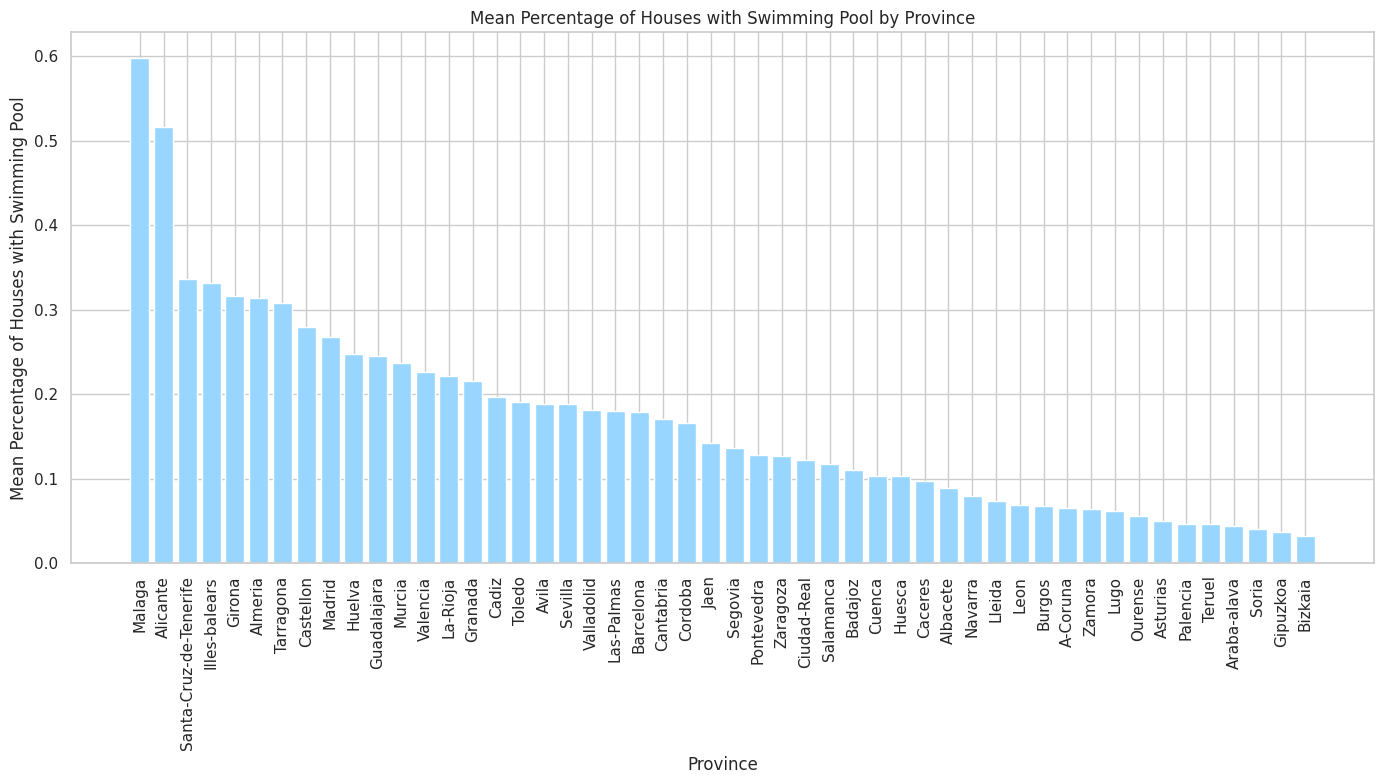

In [70]:
import matplotlib.pyplot as plt

# Group the houses by province and calculate the mean of the "Swimming Pool" column
mean_pool_per_province = Spain.groupby('Province')['Swimming_pool'].mean()

# Sort the data by mean pool percentage in descending order
mean_pool_sorted = mean_pool_per_province.sort_values(ascending=False)

# Create a vertical bar chart
fig, ax = plt.subplots(figsize=(14, 8))
x_pos = np.arange(len(mean_pool_sorted.index))
ax.bar(x_pos, mean_pool_sorted.values, align='center', color='#99d6ff')
ax.set_xticks(x_pos)
ax.set_xticklabels(mean_pool_sorted.index, rotation=90)
ax.set_xlabel('Province')
ax.set_ylabel('Mean Percentage of Houses with Swimming Pool')
ax.set_title('Mean Percentage of Houses with Swimming Pool by Province')

plt.tight_layout()
plt.savefig('province_mean_pool_percentage.png')
plt.show()


In [71]:
#Price change do not provide any valuable information so it will be better to put the percentage they usually decrease when they decrease (calculated before).

#Both countplot and histplot are visualization functions provided by the Seaborn library, but they serve different purposes and are used for different types of data:
#countplot: This function is used to display the counts of unique categorical values in a dataset. It creates a bar plot where the height of each bar represents the number of occurrences of each category in the data. countplot is specifically designed for categorical data, where each observation belongs to a distinct category, such as colors, shapes, or sizes. The x-axis represents the categories, and the y-axis represents the count of each category.
#histplot: This function is used to display the distribution of a continuous or discrete numerical variable by dividing the data into intervals (bins) and counting the number of data points within each bin. The resulting plot is a histogram, where the height of each bar represents the number of data points in each bin. histplot is designed for numerical data, such as heights, weights, or ages. The x-axis represents the bins, and the y-axis represents the count of data points within each bin.
#In summary, the main differences between countplot and histplot are:
#countplot is for categorical data, while histplot is for numerical data.
#countplot displays the count of each unique category, whereas histplot displays the distribution of the data by dividing it into bins.
#When visualizing the distribution of a discrete numerical variable with a limited number of unique values (e.g., the number of rooms in a house), it is often more appropriate to use a countplot to show the count of each unique value directly. On the other hand, for continuous numerical variables or discrete variables with a large number of unique values, a histplot is generally more suitable for visualizing the distribution of the data.

Mean squares: 163.43055817720162
Median squares: 108.0
25th percentile: 80.0
75th percentile: 168.0


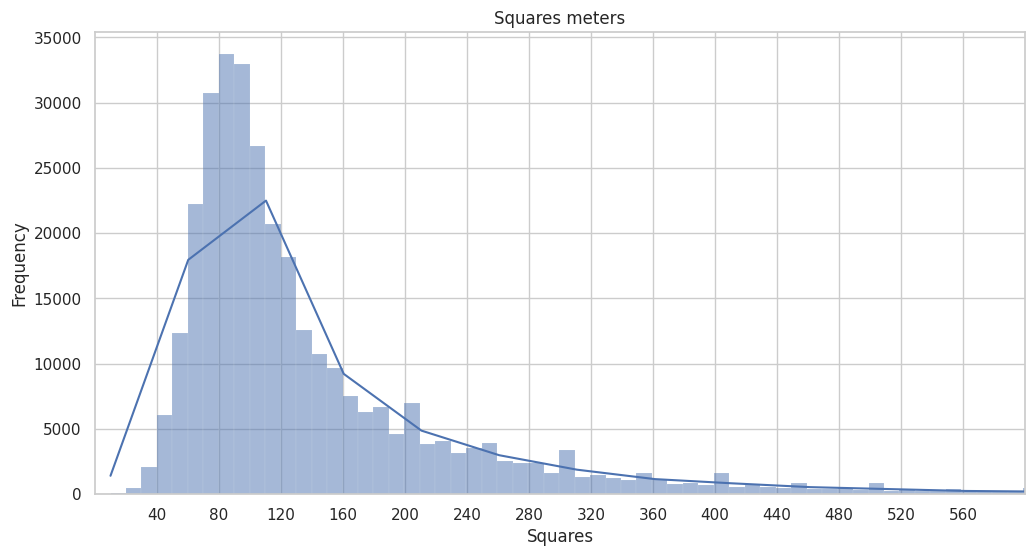

In [72]:
# Calculate the mean number of squares
mean_squares = Spain['Squares'].mean()
print("Mean squares:", mean_squares)

# Calculate the median
median_squares = Spain['Squares'].median()
print("Median squares:", median_squares)

# Calculate the 25th and 75th percentiles
percentile_25 = Spain['Squares'].quantile(0.25)
percentile_75 = Spain['Squares'].quantile(0.75)
print("25th percentile:", percentile_25)
print("75th percentile:", percentile_75)

# Set the style for the Seaborn plot
sns.set(style='whitegrid')

# Create a histogram of the 'Squares' column with a custom range
plt.figure(figsize=(12, 6))
sns.histplot(Spain, x='Squares', bins=1000, kde=True)

# Set the x-axis range
plt.xlim(0, 600)

# Set the labels and title
plt.xlabel('Squares')
plt.ylabel('Frequency')
plt.title('Squares meters')

# Set the number of X axis numbers
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=16))

# Save the plot as an image file
plt.savefig('squares_histogram.png')

# Show the plot
plt.show()

<ipython-input-73-cd70cb321245>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Type_grouped'] = df_filtered['Type'].replace({'Piso': 'Piso/Apartamento',
<ipython-input-73-cd70cb321245>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Squares_log'] = np.log1p(df_filtered['Squares'])


Type_grouped
Casa/Chalet        255.42
Estudio             49.94
Finca rústica      452.83
Piso/Apartamento   102.29
Name: Squares, dtype: float64


<ipython-input-73-cd70cb321245>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.exp(ax.get_yticks()).round(2))


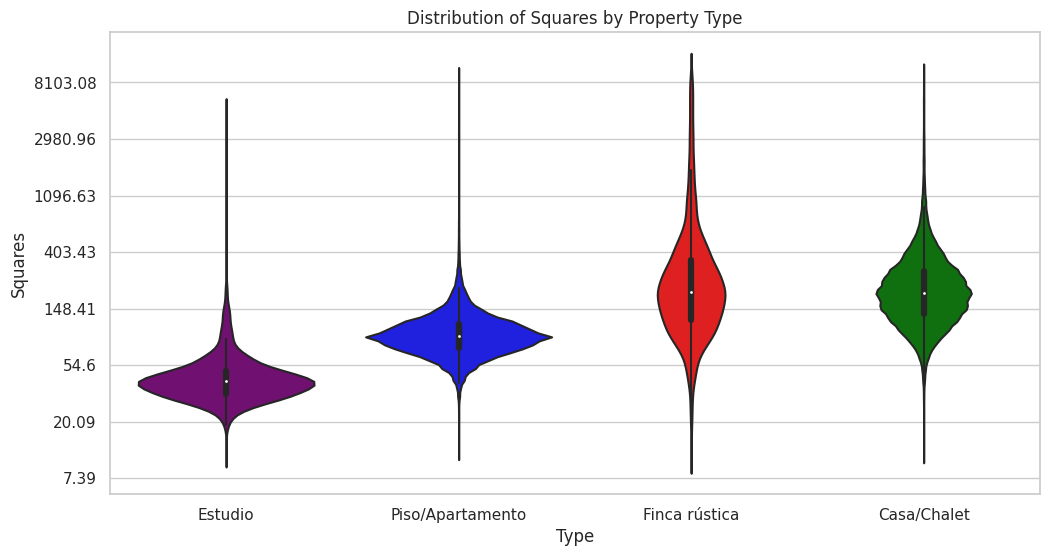

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Create a dataframe based on the type we aim to have
df_filtered = Spain[Spain['Type'].isin(['Piso', 'Apartamento', 'Casa o chalet', 'Casa adosada', 'Finca rústica', 'Estudio'])]

df_filtered['Type_grouped'] = df_filtered['Type'].replace({'Piso': 'Piso/Apartamento',
                                                           'Apartamento': 'Piso/Apartamento',
                                                           'Casa o chalet': 'Casa/Chalet',
                                                           'Casa adosada': 'Casa/Chalet',
                                                           'Finca rústica': 'Finca rústica',
                                                           'Estudio': 'Estudio'})

# Sort them
group_order = ['Estudio', 'Piso/Apartamento', 'Finca rústica', 'Casa/Chalet']
colors = {'Piso/Apartamento': 'blue', 'Casa/Chalet': 'green', 'Finca rústica': 'red', 'Estudio': 'purple'}

# Calculate the mean of each property type
mean_by_type = df_filtered.groupby('Type_grouped')['Squares'].mean()
print(mean_by_type)

# Set the style for the Seaborn plot
sns.set(style='whitegrid')

# Apply a log transformation to the 'Squares' column
df_filtered['Squares_log'] = np.log1p(df_filtered['Squares'])

# Create a violin plot of the log-transformed 'Squares' column with colors based on 'Type_grouped'
plt.figure(figsize=(12, 6))
ax = sns.violinplot(data=df_filtered, x='Type_grouped', y='Squares_log', order=group_order, palette=colors)

# Convert the y-axis ticks back to the original scale
ax.set_yticklabels(np.exp(ax.get_yticks()).round(2))

# Set the labels and title
plt.xlabel('Type')
plt.ylabel('Squares')
plt.title('Distribution of Squares by Property Type')

# Save the plot as an image file
plt.savefig('squares_violinplot.png')

# Show the plot
plt.show()


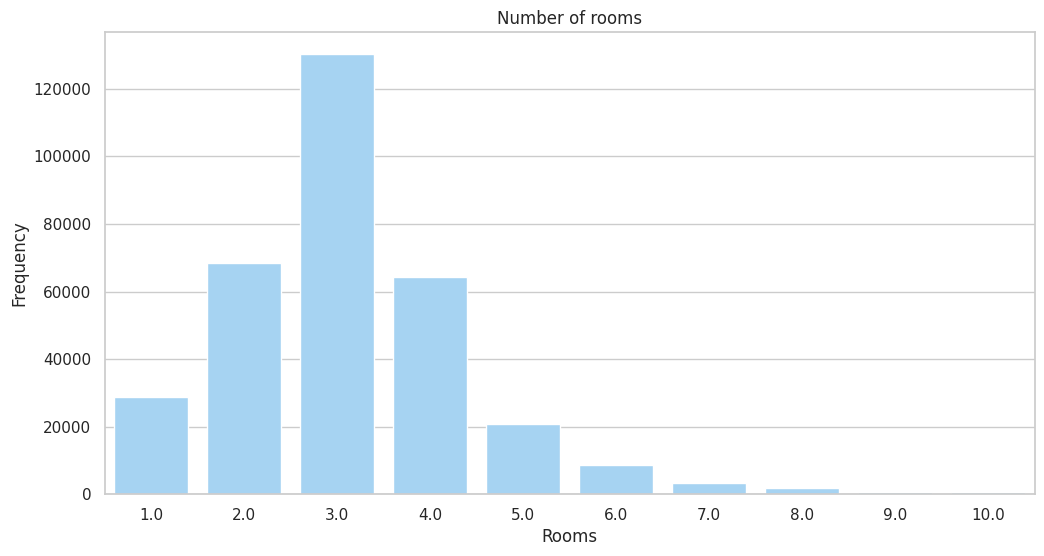

In [74]:
sns.set(style='whitegrid')

# Create a bar plot of the 'Rooms' column
plt.figure(figsize=(12, 6))
sns.countplot(x='Rooms', data=Spain, color='#99d6ff')

# Set the x-axis range
plt.xlim(-0.5, 9.5)

# Set the labels and title
plt.xlabel('Rooms')
plt.ylabel('Frequency')
plt.title('Number of rooms')

# Save the plot as an image file
plt.savefig('rooms_barplot.png')

# Show the plot
plt.show()

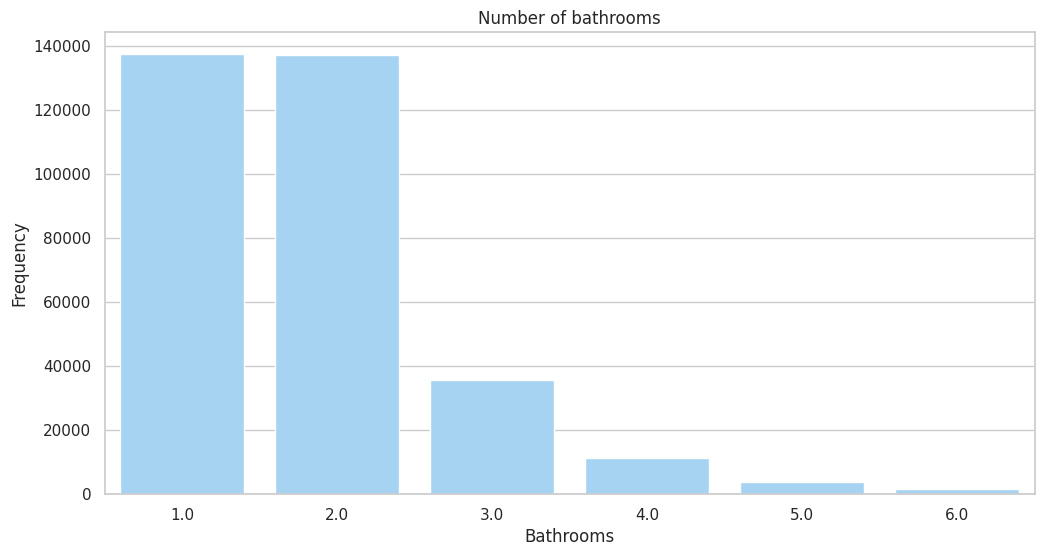

In [75]:
sns.set(style='whitegrid')

# Create a bar plot of the 'Bathrooms' column
plt.figure(figsize=(12, 6))
sns.countplot(x='Bathrooms', data=Spain, color='#99d6ff')

# Set the x-axis range
plt.xlim(-0.5, 5.5)

# Set the labels and title
plt.xlabel('Bathrooms')
plt.ylabel('Frequency')
plt.title('Number of bathrooms')

# Save the plot as an image file
plt.savefig('bathrooms_barplot.png')

# Show the plot
plt.show()


The mean age of the houses is: 37.72137615850803


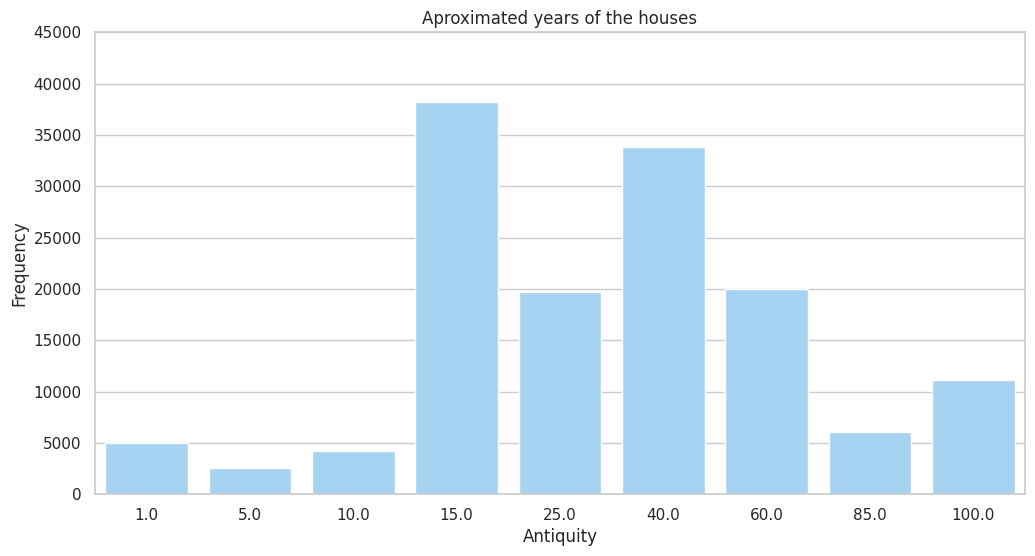

In [76]:
sns.set(style='whitegrid')

# Uniform values of Antiquity to be easier to represent
# Putting as -1 will disturb the results, it would be better to leave it as nan!
# Spain['AntiquityMidpoint'] = Spain['Antiquity'].apply(lambda x: -1 if x in ['N/A antiquity', 'N/A antiguity'] else (1 if x == 'Menos de 1 año' else (5 if x == '1 a 5 años' else (10 if x == '5 a 10 años' else (100 if x == '+ 100 años' else (int(x.split(' a ')[0].replace(' años', '')) + int(x.split(' a ')[1].replace(' años', ''))) // 2)))))
Spain['AntiquityMidpoint'] = Spain['Antiquity'].apply(lambda x: np.nan if x in ['N/A antiquity', 'N/A antiguity'] else (1 if x == 'Menos de 1 año' else (5 if x == '1 a 5 años' else (10 if x == '5 a 10 años' else (100 if x == '+ 100 años' else (int(x.split(' a ')[0].replace(' años', '')) + int(x.split(' a ')[1].replace(' años', ''))) // 2)))))


# Create a bar plot of the 'AntiquityMidpoint' column
plt.figure(figsize=(12, 6))
sns.countplot(x='AntiquityMidpoint', data=Spain, color='#99d6ff') # set the color parameter to blue

# Set the x-axis range
plt.xlim(-0.5, 8.5)

# Set the labels and title
plt.xlabel('Antiquity')
plt.ylabel('Frequency')
plt.title('Aproximated years of the houses')

# Adjust the y-axis scale
plt.ylim(0, 45000)

# Save the plot as an image file
plt.savefig('antiquity_barplot.png')

mean_age = Spain['AntiquityMidpoint'].mean()
# Print the result
print("The mean age of the houses is:", mean_age)

# Show the plot
plt.show()


The mean age of the houses is: 37.72137615850803


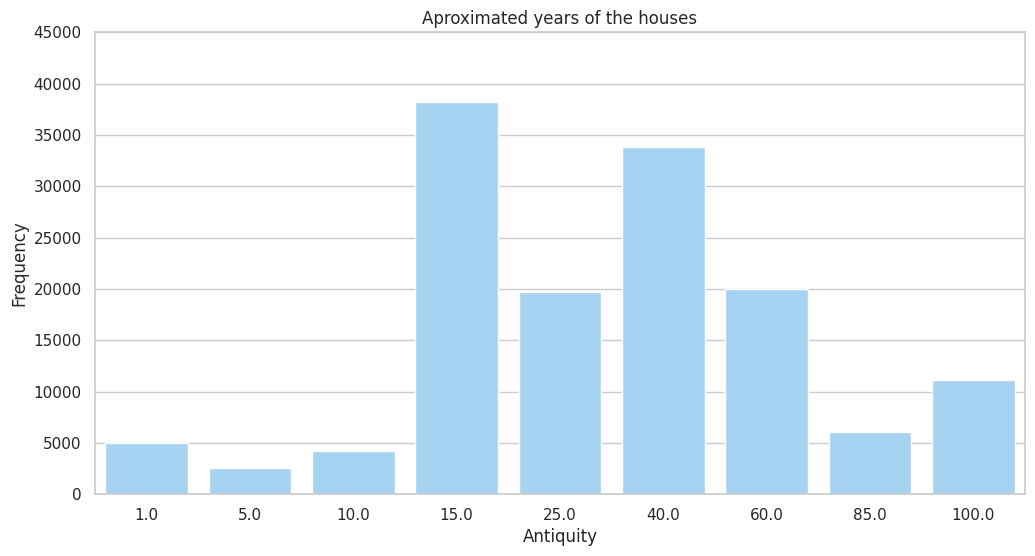

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style='whitegrid')

# Uniform values of Antiquity to be easier to represent
# Putting as -1 will disturb the results, it would be better to leave it as nan!
# Spain['AntiquityMidpoint'] = Spain['Antiquity'].apply(lambda x: -1 if x in ['N/A antiquity', 'N/A antiguity'] else (1 if x == 'Menos de 1 año' else (5 if x == '1 a 5 años' else (10 if x == '5 a 10 años' else (100 if x == '+ 100 años' else (int(x.split(' a ')[0].replace(' años', '')) + int(x.split(' a ')[1].replace(' años', ''))) // 2)))))
Spain['AntiquityMidpoint'] = Spain['Antiquity'].apply(lambda x: np.nan if x in ['N/A antiquity', 'N/A antiguity'] else (1 if x == 'Menos de 1 año' else (5 if x == '1 a 5 años' else (10 if x == '5 a 10 años' else (100 if x == '+ 100 años' else (int(x.split(' a ')[0].replace(' años', '')) + int(x.split(' a ')[1].replace(' años', ''))) // 2)))))


# Create a bar plot of the 'AntiquityMidpoint' column
plt.figure(figsize=(12, 6))
sns.countplot(x='AntiquityMidpoint', data=Spain, color='#99d6ff') # set the color parameter to blue

# Set the x-axis range
plt.xlim(-0.5, 8.5)

# Set the labels and title
plt.xlabel('Antiquity')
plt.ylabel('Frequency')
plt.title('Aproximated years of the houses')

# Adjust the y-axis scale
plt.ylim(0, 45000)

# Save the plot as an image file
plt.savefig('antiquity_barplot.png')

mean_age = Spain['AntiquityMidpoint'].mean()
# Print the result
print("The mean age of the houses is:", mean_age)

# Show the plot
plt.show()

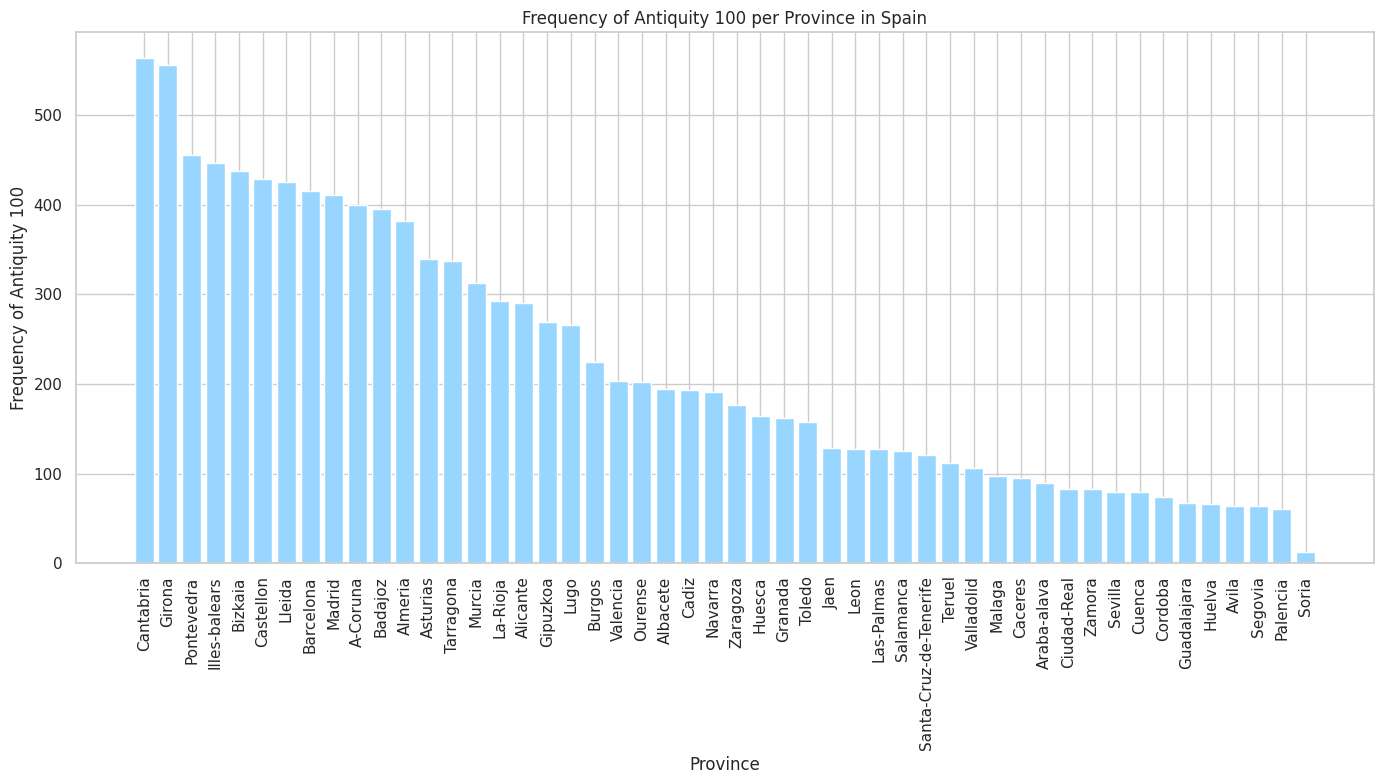

In [78]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the data to include only rows with antiquity equal to 100
antiquity_100 = Spain[Spain['AntiquityMidpoint'] == 100]

# Count the frequency of antiquity equal to 100 per province
frequency_antiquity_100_per_province = antiquity_100['Province'].value_counts()

# Sort the data in ascending order
frequency_antiquity_100_per_province_sorted = frequency_antiquity_100_per_province.sort_values(ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(14, 8))
x_pos = np.arange(len(frequency_antiquity_100_per_province_sorted.index))
plt.bar(x_pos, frequency_antiquity_100_per_province_sorted.values, align='center', color='#99d6ff')
plt.xticks(x_pos, frequency_antiquity_100_per_province_sorted.index, rotation=90)
plt.xlabel('Province')
plt.ylabel('Frequency of Antiquity 100')
plt.title('Frequency of Antiquity 100 per Province in Spain')
plt.tight_layout()
plt.savefig('province_frequency_antiquity_100.png')
plt.show()


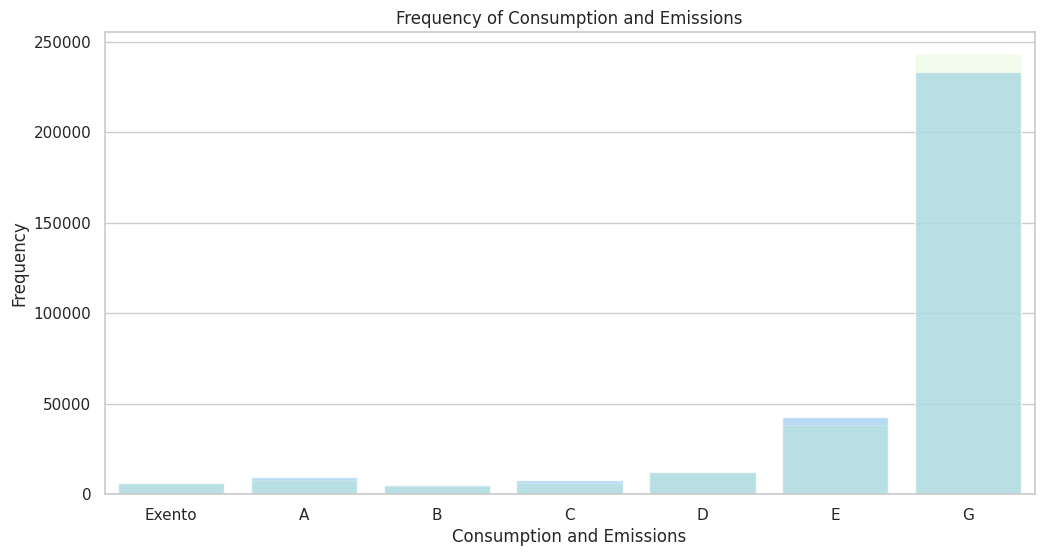

In [79]:
# Here we can see how comsumption and emition overlaps 

# Filter out the rows that contain 'N/A consumption'
Spain_filtered = Spain[Spain['Consumption'] != 'N/A consumption']

# Filter out the rows that contain 'N/A emitions'
Spain_filtered = Spain_filtered[Spain_filtered['Emitions'] != 'N/A emitions']

# Set the order of the values in the 'Consumption' column to be clearer
consumption_order = ['Exento', 'A', 'B', 'C', 'D', 'E', 'G']

# Set the style for the Seaborn plot
sns.set(style='whitegrid')

# Create a count plot of the 'Consumption' column
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='Consumption', data=Spain_filtered, color='#99d6ff', order=consumption_order, alpha=0.8)

# Create a count plot of the 'Emitions' column on the same axis
sns.countplot(x='Emitions', data=Spain_filtered, color='#b3ff99', order=consumption_order, alpha=0.2, ax=ax)

# Set the x-axis range
plt.xlim(-0.5, 6.5)

# Set the labels and title
plt.xlabel('Consumption and Emissions')
plt.ylabel('Frequency')
plt.title('Frequency of Consumption and Emissions')

# Save the plot as an image file
plt.savefig('consumption_emitions_countplot.png')

# Show the plot
plt.show()

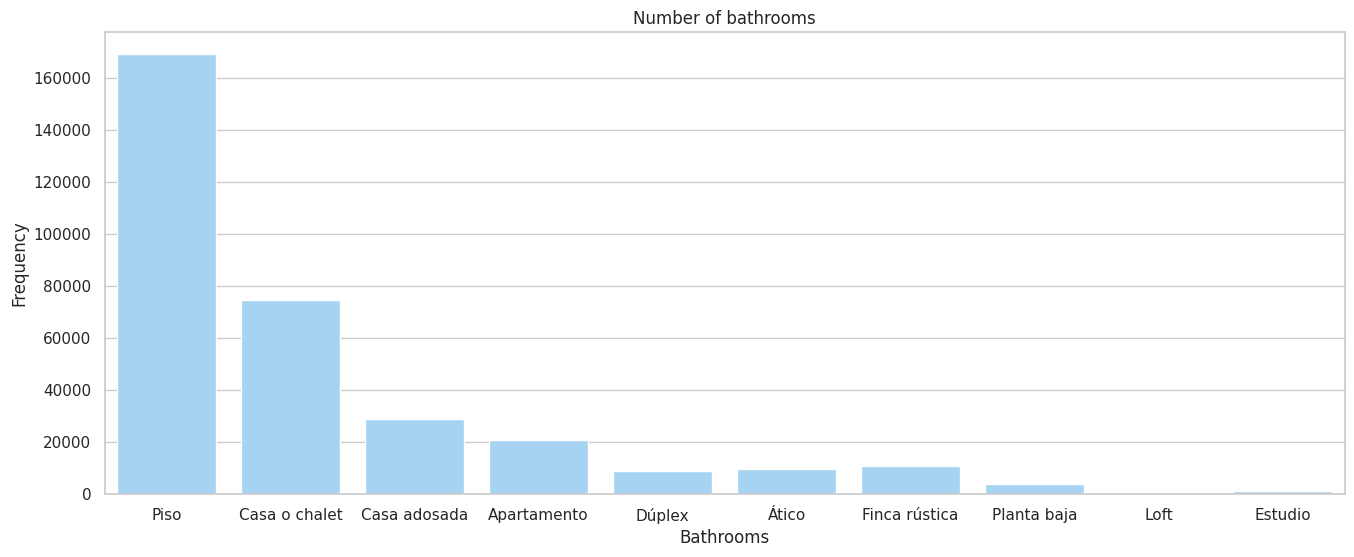

In [80]:
sns.set(style='whitegrid')

# Create a bar plot of the 'Bathrooms' column
plt.figure(figsize=(16, 6))
sns.countplot(x='Type', data=Spain, color='#99d6ff')

# Set the x-axis range
plt.xlim(-0.5, 9.5)

# Set the labels and title
plt.xlabel('Bathrooms')
plt.ylabel('Frequency')
plt.title('Number of bathrooms')

# Save the plot as an image file
plt.savefig('bathrooms_barplot.png')

# Show the plot
plt.show()

False   61.27
True    38.73
Name: Elevator, dtype: float64


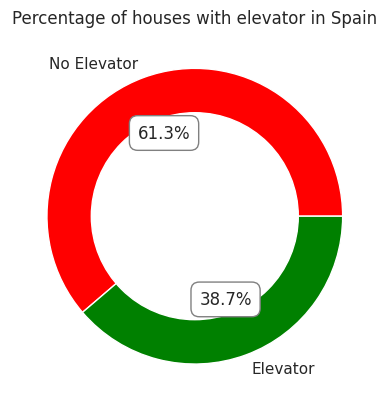

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la cuenta de los valores verdaderos y falsos
availability_counts = Spain['Elevator'].value_counts()

# Calcular los porcentajes
availability_perc = availability_counts / len(Spain) * 100
print(availability_perc)
# Crear un gráfico de tipo donut
fig, ax = plt.subplots()
wedges, _, labels = ax.pie(availability_perc, labels=['No Elevator', 'Elevator'], colors=['red', 'green'], wedgeprops={'width': 0.5}, autopct='%1.01f%%')

# Agregar un círculo blanco para crear el efecto de un donut
circle = plt.Circle((0,0), 0.7, color='white')
ax.add_artist(circle)

# Agregar etiquetas de porcentaje con borde y espacio adicional
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = wedge.r * 0.6 * np.cos(np.radians(angle))
    y = wedge.r * 0.6 * np.sin(np.radians(angle))
    bbox = dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1)
    ax.text(x, y, '{:.1f}%'.format(availability_perc[i]), ha='center', va='center', bbox=bbox)

# Agregar un título
ax.set_title('Percentage of houses with elevator in Spain')

plt.show()


False   51.22
True    48.78
Name: Parking, dtype: float64


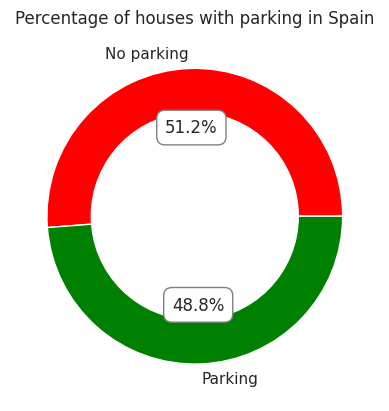

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la cuenta de los valores verdaderos y falsos
availability_counts = Spain['Parking'].value_counts()

# Calcular los porcentajes
availability_perc = availability_counts / len(Spain) * 100
print(availability_perc)
# Crear un gráfico de tipo donut
fig, ax = plt.subplots()
wedges, _, labels = ax.pie(availability_perc, labels=['No parking', 'Parking'], colors=['red', 'green'], wedgeprops={'width': 0.5}, autopct='%1.01f%%')

# Agregar un círculo blanco para crear el efecto de un donut
circle = plt.Circle((0,0), 0.7, color='white')
ax.add_artist(circle)

# Agregar etiquetas de porcentaje con borde y espacio adicional
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = wedge.r * 0.6 * np.cos(np.radians(angle))
    y = wedge.r * 0.6 * np.sin(np.radians(angle))
    bbox = dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1)
    ax.text(x, y, '{:.1f}%'.format(availability_perc[i]), ha='center', va='center', bbox=bbox)

# Agregar un título
ax.set_title('Percentage of houses with parking in Spain')

plt.show()


False   80.85
True    19.15
Name: Swimming_pool, dtype: float64


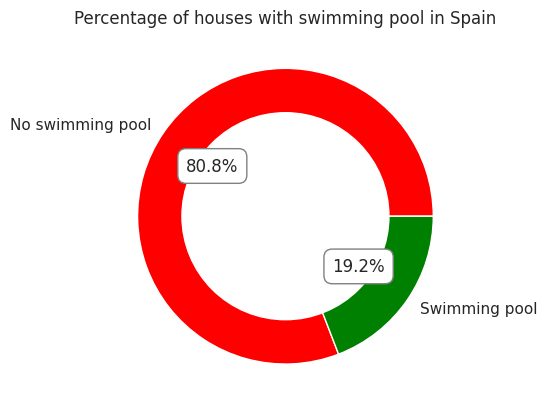

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la cuenta de los valores verdaderos y falsos
availability_counts = Spain['Swimming_pool'].value_counts()

# Calcular los porcentajes
availability_perc = availability_counts / len(Spain) * 100
print(availability_perc)
# Crear un gráfico de tipo donut
fig, ax = plt.subplots()
wedges, _, labels = ax.pie(availability_perc, labels=['No swimming pool', 'Swimming pool'], colors=['red', 'green'], wedgeprops={'width': 0.5}, autopct='%1.01f%%')

# Agregar un círculo blanco para crear el efecto de un donut
circle = plt.Circle((0,0), 0.7, color='white')
ax.add_artist(circle)

# Agregar etiquetas de porcentaje con borde y espacio adicional
for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 - wedge.theta1)/2. + wedge.theta1
    x = wedge.r * 0.6 * np.cos(np.radians(angle))
    y = wedge.r * 0.6 * np.sin(np.radians(angle))
    bbox = dict(boxstyle='round,pad=0.5', fc='white', ec='gray', lw=1)
    ax.text(x, y, '{:.1f}%'.format(availability_perc[i]), ha='center', va='center', bbox=bbox)

# Agregar un título
ax.set_title('Percentage of houses with swimming pool in Spain')

plt.show()


<ipython-input-84-ed50b2bd4477>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = Spain.corr() # get the correlation matrix of your DataFrame


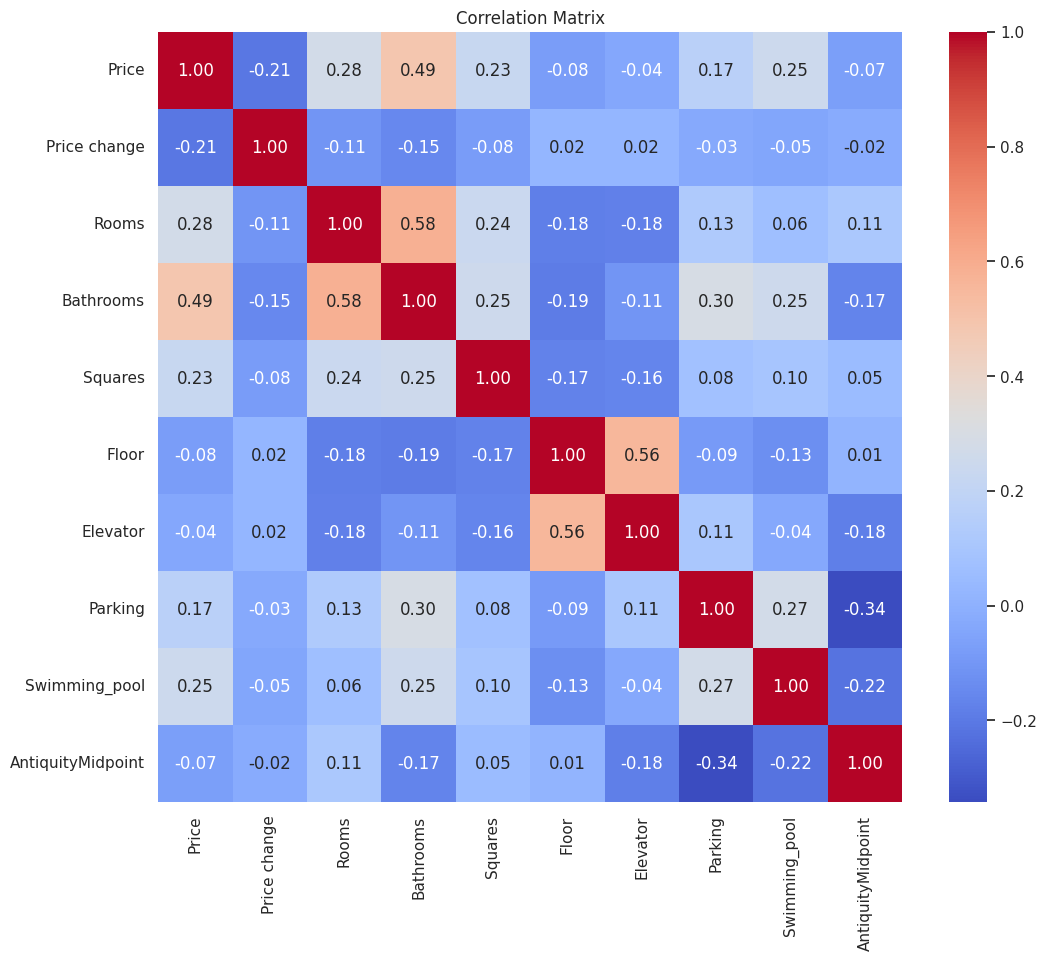

In [84]:
# Another correlation matrix

corr_matrix = Spain.corr() # get the correlation matrix of your DataFrame
sns.set(font_scale=1.0) # set the font scale to 1.0
plt.figure(figsize=(12, 10)) # set the figure size to 12 inches by 10 inches
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f') # create a heatmap of the correlation matrix
plt.title('Correlation Matrix') # set the title of the plot
plt.show() # show the plot

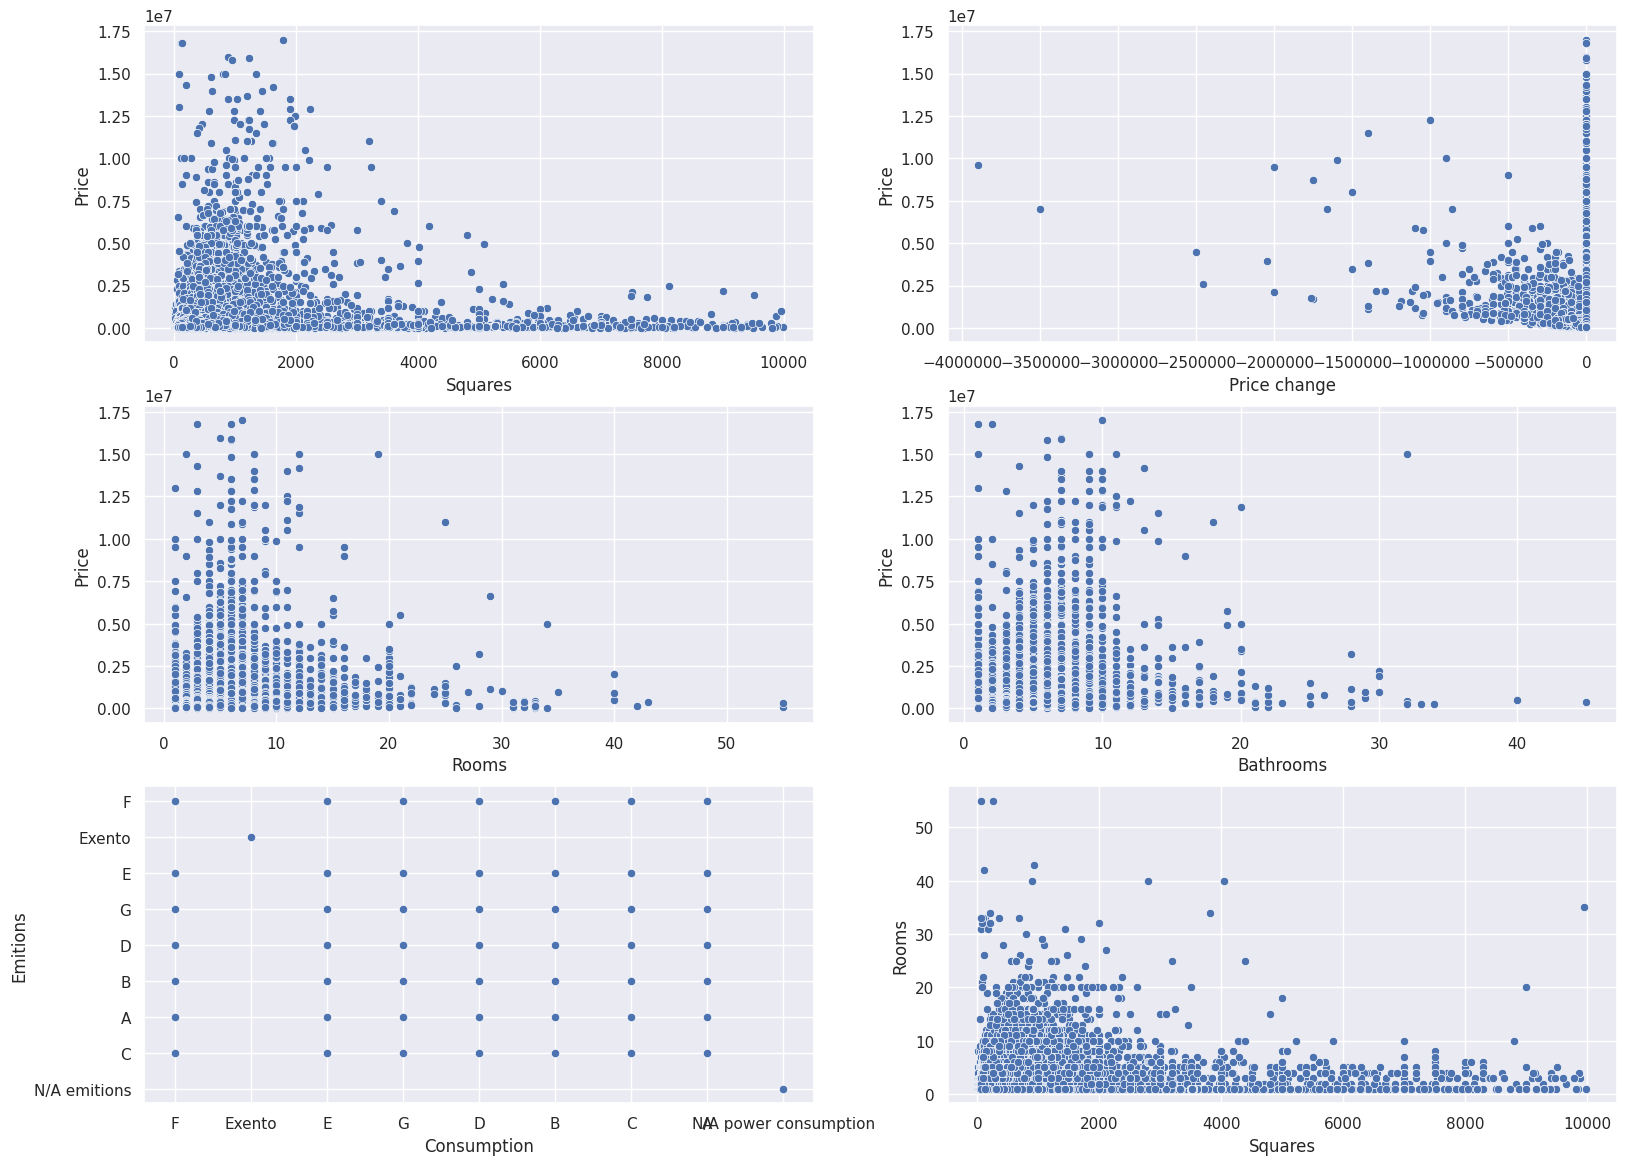

In [85]:
# Representing some relations with scatterplot that can be interesting
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(19,14))
ax1,ax2,ax3,ax4,ax5,ax6 = axs.ravel()

sns.scatterplot(data=Spain, x='Squares', y='Price', ax=ax1)

sns.scatterplot(data=Spain, x='Price change', y='Price', ax=ax2)

sns.scatterplot(data=Spain, x='Rooms', y='Price', ax=ax3)

sns.scatterplot(data=Spain, x='Bathrooms', y='Price', ax=ax4)

sns.scatterplot(data=Spain, x='Consumption', y='Emitions', ax=ax5)

sns.scatterplot(data=Spain, x='Squares', y='Rooms', ax=ax6)

plt.show()

In [86]:
# Calculate the mean AntiquityMidpoint per province
mean_antiquity_per_province = Spain.groupby('Province')['AntiquityMidpoint'].mean().round(2)

# Create a table to store the results
table = []
for province, mean_antiquity in mean_antiquity_per_province.items():
    table.append([province, mean_antiquity])

# Print the table using tabulate
print(tabulate(table, headers=['Province', 'Mean AntiquityMidpoint']))


Province                  Mean AntiquityMidpoint
----------------------  ------------------------
A-Coruna                                   39.34
Albacete                                   38.38
Alicante                                   36.46
Almeria                                    30.54
Araba-alava                                44.7
Asturias                                   39.65
Avila                                      35.92
Badajoz                                    44.54
Barcelona                                  43.16
Bizkaia                                    52.93
Burgos                                     43.34
Caceres                                    39.27
Cadiz                                      33.69
Cantabria                                  41.17
Castellon                                  34.45
Ciudad-Real                                34.6
Cordoba                                    35.33
Cuenca                                     38.76
Gipuzkoa              

In [87]:
# Consumption and Emition per province

import pandas as pd
from tabulate import tabulate

# Realizar una copia del conjunto de datos de España
Spain_copy = Spain.copy()

# Eliminar los valores nulos en Consumption y Emitions
Spain_copy = Spain_copy.dropna(subset=['Consumption', 'Emitions'])

# Asignar valores numéricos a los niveles de consumo y emisiones
consumption_mapping = {'Exento': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
emissions_mapping = {'Exento': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}

# Mapear los valores en el DataFrame copiado
Spain_copy['Consumption'] = Spain_copy['Consumption'].map(consumption_mapping)
Spain_copy['Emitions'] = Spain_copy['Emitions'].map(emissions_mapping)

Spain_copy["Emitions"].describe()
# Calcular el promedio de consumo y emisiones por provincia
mean_consumption_per_province = Spain_copy.groupby('Province')['Consumption'].mean().round(2)
mean_emissions_per_province = Spain_copy.groupby('Province')['Emitions'].mean().round(2)

# Crear una tabla para almacenar los resultados
table = []
for province, mean_consumption in mean_consumption_per_province.items():
    mean_emissions = mean_emissions_per_province.get(province, float('nan'))
    table.append([province, mean_consumption, mean_emissions])

# Imprimir la tabla usando tabulate
print(tabulate(table, headers=['Province', 'Mean Consumption', 'Mean Emitions']))

# Calcular el promedio de consumo y emisiones para todas las provincias
average_consumption = Spain_copy['Consumption'].mean().round(2)
average_emissions = Spain_copy['Emitions'].mean().round(2)

# Imprimir el promedio de consumo y emisiones en un solo valor
print("Average Consumption: ", average_consumption)
print("Average Emissions: ", average_emissions)


Province                  Mean Consumption    Mean Emitions
----------------------  ------------------  ---------------
A-Coruna                              6.05             6.13
Albacete                              6.2              6.34
Alicante                              6.5              6.62
Almeria                               6.23             6.3
Araba-alava                           5.58             5.61
Asturias                              5.83             5.93
Avila                                 5.86             6.06
Badajoz                               6.06             6.26
Barcelona                             5.74             5.7
Bizkaia                               6.16             6.09
Burgos                                6.2              6.28
Caceres                               6.17             6.37
Cadiz                                 6.33             6.46
Cantabria                             6.2              6.28
Castellon                             6.17

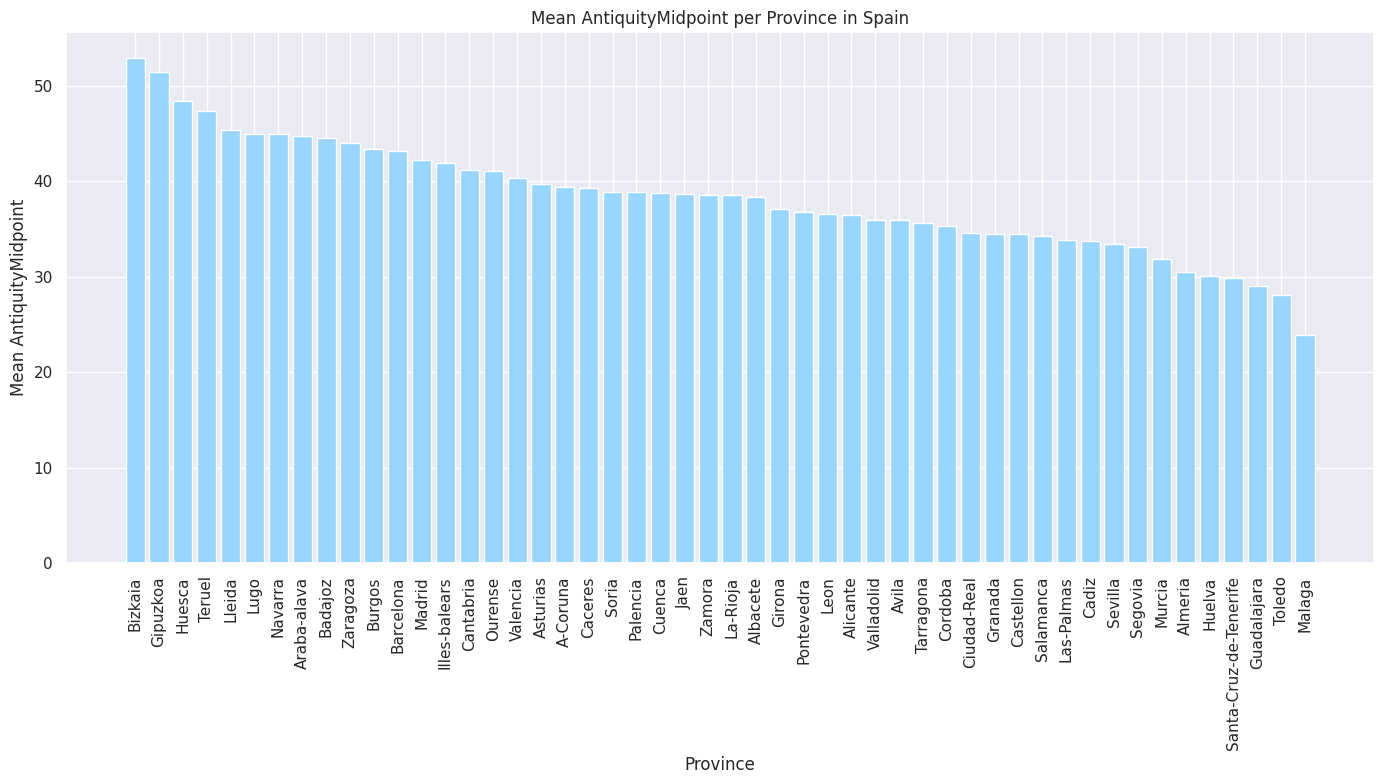

In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Sort the data in ascending order
mean_antiquity_per_province_sorted = mean_antiquity_per_province.sort_values(ascending=False)

# Create a vertical bar chart
plt.figure(figsize=(14, 8))
x_pos = np.arange(len(mean_antiquity_per_province_sorted.index))
plt.bar(x_pos, mean_antiquity_per_province_sorted.values, align='center', color='#99d6ff')
plt.xticks(x_pos, mean_antiquity_per_province_sorted.index, rotation=90)
plt.xlabel('Province')
plt.ylabel('Mean AntiquityMidpoint')
plt.title('Mean AntiquityMidpoint per Province in Spain')
plt.tight_layout()
plt.savefig('province_mean_antiquity.png')
plt.show()


# Predictive Model - Filling missing fields with Machine Leaning

In [89]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt


Spain.to_csv('Spain_cleaned.csv', index=False)
Spain = pd.read_csv('Spain_cleaned.csv')
#files.download('Spain_cleaned.csv')

In [90]:
Spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328462 entries, 0 to 328461
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Link               328462 non-null  object 
 1   Title              328461 non-null  object 
 2   Price              328462 non-null  float64
 3   Price change       328462 non-null  float64
 4   Rooms              328462 non-null  float64
 5   Bathrooms          328462 non-null  float64
 6   Squares            328462 non-null  float64
 7   Floor              260283 non-null  float64
 8   Description        322714 non-null  object 
 9   Type               328462 non-null  object 
 10  Antiquity          328462 non-null  object 
 11  Orientation        328462 non-null  object 
 12  Heating            328462 non-null  object 
 13  Hot water          328462 non-null  object 
 14  Condition state    328462 non-null  object 
 15  Floor.1            328462 non-null  object 
 16  El

Average R2 score: 0.9425483454168179
Average MAE: 0.22283132267183423
Average RMSE: 0.4292078708494808


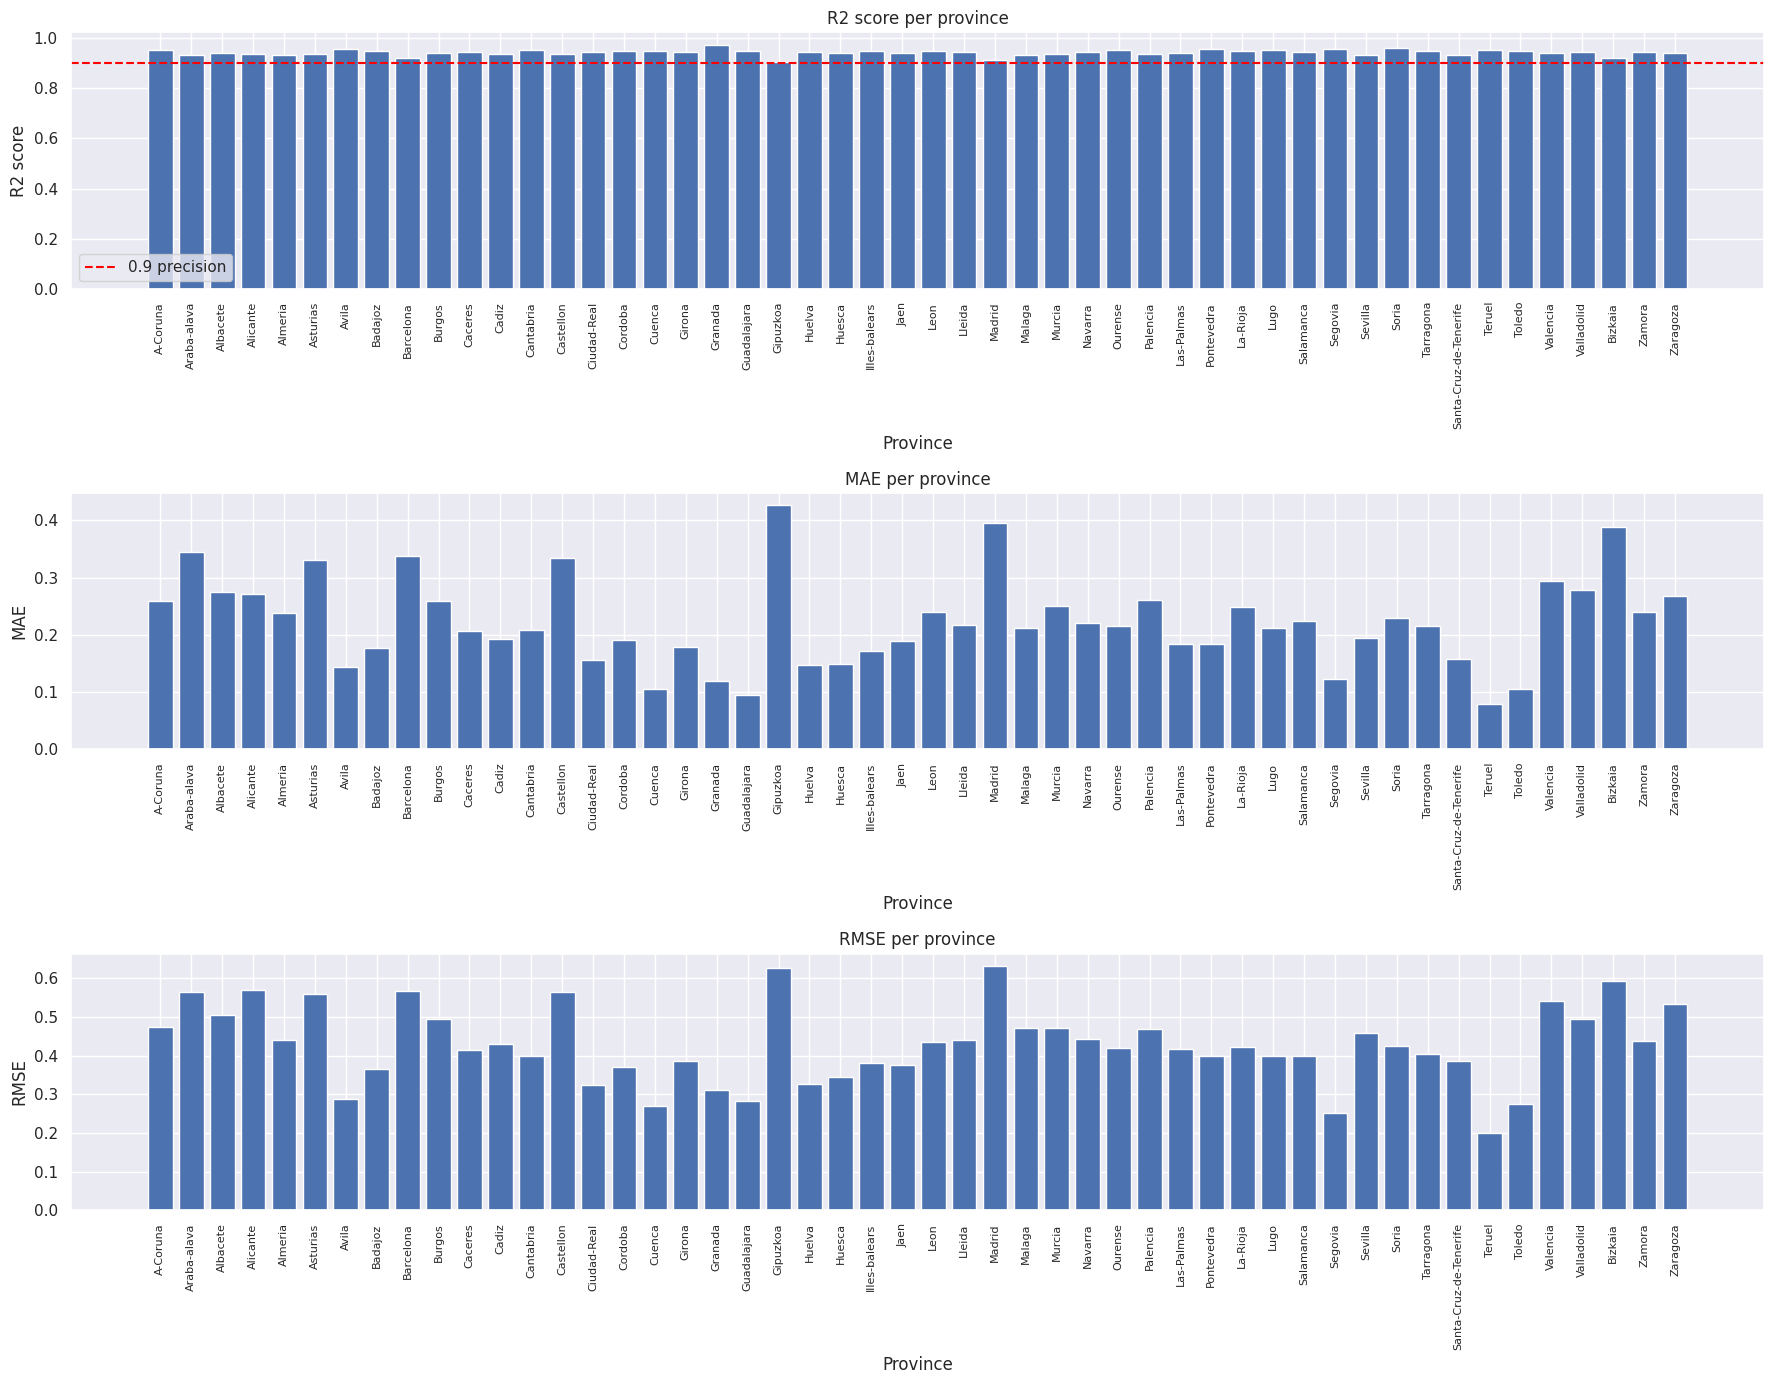

In [91]:
#####################################################
## PREDICT AND FILL FLOOR VALUE AT PROVINCES LEVEL ##
#####################################################

# This floors are going to be a float value, it's not going to output 1,2,3,4,5... it will be e.g: 2.23.

# Obtain provinces
provincias = Spain['Province'].unique()

# Store the values for each province
r2_values = []
mae_values = []
rmse_values = []

for provincia in provincias:
    
    provincia_data = Spain[Spain['Province'] == provincia]
    # Convert bool to int values
    bool_columns = ["Elevator", "Parking", "Swimming_pool"]
    Spain[bool_columns] = Spain[bool_columns].astype(int)
    
    # Divide dataset in training values and test values. I'm going to train with valid data and the test one will be the nulls.
    train_data = provincia_data[provincia_data['Floor'].notnull()]
    test_data = provincia_data[provincia_data['Floor'].isnull()]

    # Prepare data for training
    columns_to_drop = ["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water",
                       "Condition state", "Floor.1", "Furnished", "Ubication", "AntiquityMidpoint", "Province"]
    X_train = train_data.drop('Floor', axis=1).drop(columns_to_drop, axis=1)
    y_train = train_data['Floor']

    # Prepare data for testing
    X_test = test_data.drop('Floor', axis=1).drop(columns_to_drop, axis=1)

    ## One-Hot encoding ##
    categorical_columns = ["City","Type", "Emitions", "Consumption"]
    X_train = pd.get_dummies(X_train, columns=categorical_columns)
    X_test  = pd.get_dummies(X_test,  columns=categorical_columns)
    X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

    # Train with the desired model
    model = RandomForestRegressor()
    #model = XGBRegressor()
    model.fit(X_train, y_train)

    # Fill missing floor values with the ones we predicted 
    predicted_values = model.predict(X_test)                                                            #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES
    Spain.loc[(Spain['Province'] == provincia) & (Spain['Floor'].isnull()), 'Floor'] = predicted_values #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES

    # Calculate accuracy in that province
    r2 = r2_score(train_data['Floor'], model.predict(X_train))
    mae = mean_absolute_error(train_data['Floor'], model.predict(X_train))
    rmse = mean_squared_error(train_data['Floor'], model.predict(X_train), squared=False)

    # Add it to the list of results for all provinces
    r2_values.append(r2)
    mae_values.append(mae)
    rmse_values.append(rmse)

    #Print values of the province
    #print("Province:", provincia)
    #print("R2 score:", r2)
    #print("MAE:", mae)
    #print("RMSE:", rmse)
    #print()

# Average metrics
avg_r2 = sum(r2_values) / len(r2_values)
avg_mae = sum(mae_values) / len(mae_values)
avg_rmse = sum(rmse_values) / len(rmse_values)
print("Average R2 score:", avg_r2)
print("Average MAE:", avg_mae)
print("Average RMSE:", avg_rmse)

# Create the graphs
plt.figure(figsize=(18, 14))

# R2 score
plt.subplot(3, 1, 1)
plt.bar(provinces, r2_values)
plt.xlabel('Province')
plt.ylabel('R2 score')
plt.title('R2 score per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
desired_r2 = 0.9  # Reference value
plt.axhline(desired_r2, color='red', linestyle='--', label='0.9 precision')
plt.legend()


# MAE
plt.subplot(3, 1, 2)
plt.bar(provinces, mae_values)
plt.xlabel('Province')
plt.ylabel('MAE')
plt.title('MAE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)


# RMSE
plt.subplot(3, 1, 3)
plt.bar(provinces, rmse_values)
plt.xlabel('Province')
plt.ylabel('RMSE')
plt.title('RMSE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()

plt.savefig('ml_province_floor_metrics.png')

plt.show()


Average R2 score: 0.9136147705093777
Average MAE: 5.377483573571128
Average RMSE: 7.817791970602764


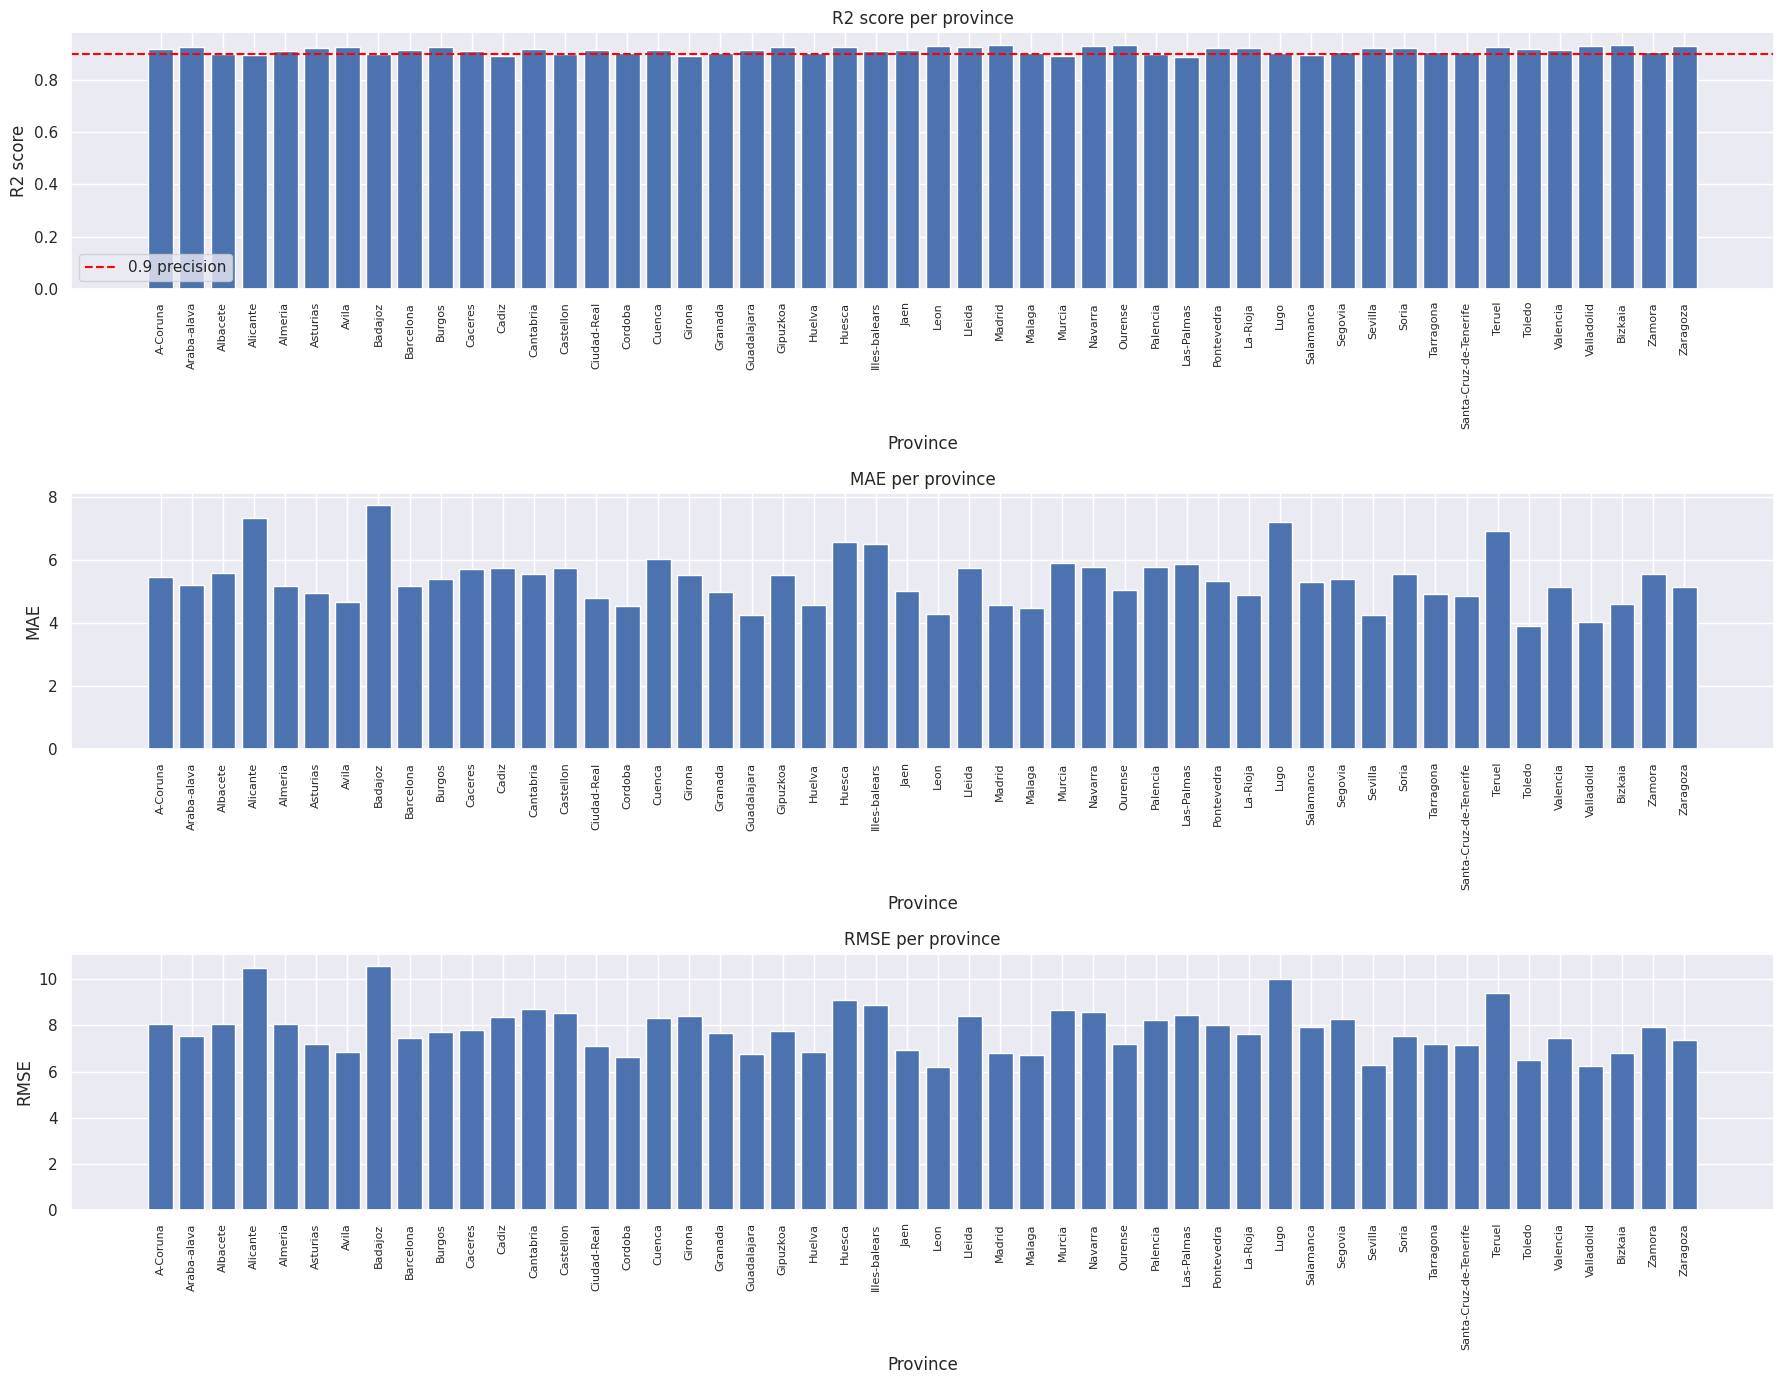

In [92]:
########################################################
## PREDICT AND FILL ANTIQUITY VALUE AT PROVINCE LEVEL ##
########################################################

# This antiquity is going to be a value that will not be inside the midpoint, it's not going to output 1,5,25... it will be e.g: 12.23 years.

# Obtain provinces
provincias = Spain['Province'].unique()

# Store the values for each province
r2_values = []
mae_values = []
rmse_values = []

for provincia in provincias:
    
    provincia_data = Spain[Spain['Province'] == provincia]

    # Convert bool to int values
    bool_columns = ["Elevator", "Parking", "Swimming_pool"]
    Spain[bool_columns] = Spain[bool_columns].astype(int)

    # Divide dataset in training values and test values. I'm going to train with valid data and the test one will be the nulls.
    train_data = provincia_data[provincia_data['AntiquityMidpoint'].notnull()]
    test_data = provincia_data[provincia_data['AntiquityMidpoint'].isnull()]

    # Prepare data for training
    columns_to_drop = ["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water",
                       "Condition state", "Floor.1", "Furnished", "Ubication"]
    X_train = train_data.drop('AntiquityMidpoint', axis=1).drop(columns_to_drop, axis=1)
    y_train = train_data['AntiquityMidpoint']

    # Prepare data for testing
    X_test = test_data.drop('AntiquityMidpoint', axis=1).drop(columns_to_drop, axis=1)

    ## One-Hot encoding ##
    categorical_columns = ["Province", "Type", "Emitions", "Consumption", "City"]
    X_train = pd.get_dummies(X_train, columns=categorical_columns)
    X_test  = pd.get_dummies(X_test,  columns=categorical_columns)
    X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

    # Train with the desired model
    #model = XGBRegressor()
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # Fill missing floor values with the ones we predicted 
    predicted_values = model.predict(X_test)                                                                                    #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES
    Spain.loc[(Spain['Province'] == provincia) & (Spain['AntiquityMidpoint'].isnull()), 'AntiquityMidpoint'] = predicted_values #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES

    # Calculate accuracy in that province
    r2 = r2_score(train_data['AntiquityMidpoint'], model.predict(X_train))
    mae = mean_absolute_error(train_data['AntiquityMidpoint'], model.predict(X_train))
    rmse = mean_squared_error(train_data['AntiquityMidpoint'], model.predict(X_train), squared=False)

    # Add it to the list of results for all provinces
    r2_values.append(r2)
    mae_values.append(mae)
    rmse_values.append(rmse)

    # Print values of the province
    #print("Province:", provincia)
    #print("R2 score:", r2)
    #print("MAE:", mae)
    #print("RMSE:", rmse)
    #print()

# Average metrics
avg_r2 = sum(r2_values) / len(r2_values)
avg_mae = sum(mae_values) / len(mae_values)
avg_rmse = sum(rmse_values) / len(rmse_values)
print("Average R2 score:", avg_r2)
print("Average MAE:", avg_mae)
print("Average RMSE:", avg_rmse)

# Create the graphs
plt.figure(figsize=(18, 14))

# R2 score
plt.subplot(3, 1, 1)
plt.bar(provinces, r2_values)
plt.xlabel('Province')
plt.ylabel('R2 score')
plt.title('R2 score per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
desired_r2 = 0.9  # Valor de referencia deseado
plt.axhline(desired_r2, color='red', linestyle='--', label='0.9 precision')
plt.legend()


# MAE
plt.subplot(3, 1, 2)
plt.bar(provinces, mae_values)
plt.xlabel('Province')
plt.ylabel('MAE')
plt.title('MAE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)


# RMSE
plt.subplot(3, 1, 3)
plt.bar(provinces, rmse_values)
plt.xlabel('Province')
plt.ylabel('RMSE')
plt.title('RMSE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
plt.tight_layout()
plt.savefig('ml_province_antiquity_metrics.png')
plt.show()


In [93]:
#################################################
## PREDICT AND FILL FLOOR VALUE AT SPAIN LEVEL ##
#################################################

# If you fill the values at province level and then compute this model, this is going to be higher results as it will have more data. In case you want to compare models, please do not fill them.
# This floor value is going to be a float as it's a prediction, it's not going to output 1,2,3... it will be e.g: 2.23.

# Convert bool to int values
bool_columns = ["Elevator", "Parking", "Swimming_pool"]
Spain[bool_columns] = Spain[bool_columns].astype(int)

# Divide dataset in training values and test values. I'm going to train with valid data and the test one will be the nulls.
train_data = Spain[Spain['Floor'].notnull()]
test_data = Spain[Spain['Floor'].isnull()]

# Prepare data for training
columns_to_drop = ["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water",
                    "Condition state", "Floor.1", "Furnished", "Ubication", "AntiquityMidpoint", "City"]
X_train = train_data.drop('Floor', axis=1).drop(columns_to_drop, axis=1)
y_train = train_data['Floor']

# Prepare data for testing
X_test = test_data.drop('Floor', axis=1).drop(columns_to_drop, axis=1)

## One-Hot encoding ##
categorical_columns = ["Province","Type", "Emitions", "Consumption"]
X_train = pd.get_dummies(X_train, columns=categorical_columns)
X_test  = pd.get_dummies(X_test,  columns=categorical_columns)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Train with the desired model
model = XGBRegressor()
#model = RandomForestRegressor()

model.fit(X_train, y_train)

# Fill missing floor values with the ones we predicted
# Province level has shown lower MAE and RMSE. R2 is almost the same. Overall let's use Province level with RandomForest.
#predicted_values = model.predict(X_test)                       #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES
#Spain.loc[Spain['Floor'].isnull(), 'Floor'] = predicted_values #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES

# Calculate accuracy on training set
r2_train = r2_score(train_data['Floor'], model.predict(X_train))
mae_train = mean_absolute_error(train_data['Floor'], model.predict(X_train))
rmse_train = mean_squared_error(train_data['Floor'], model.predict(X_train), squared=False)

print("R2 score:", r2_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

R2 score: 0.589458711849496
MAE: 0.6810672056235564
RMSE: 1.1598481551051085


In [94]:
#####################################################
## PREDICT AND FILL ANTIQUITY VALUE AT SPAIN LEVEL ##
#####################################################

# This antiquity is going to be a value that will not be inside the midpoint, it's not going to output 1,5,25... it will be e.g: 12.23 years.

# Convert bool to int values
bool_columns = ["Elevator", "Parking", "Swimming_pool"]
Spain[bool_columns] = Spain[bool_columns].astype(int)

# Divide dataset in training values and test values. I'm going to train with valid data and the test one will be the nulls.
train_data = Spain[Spain['AntiquityMidpoint'].notnull()]
test_data = Spain[Spain['AntiquityMidpoint'].isnull()]

# Prepare data for training
columns_to_drop = ["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water",
                    "Condition state", "Floor.1", "Furnished", "Ubication", "City"]
X_train = train_data.drop('AntiquityMidpoint', axis=1).drop(columns_to_drop, axis=1)
y_train = train_data['AntiquityMidpoint']

# Prepare data for testing
X_test = test_data.drop('AntiquityMidpoint', axis=1).drop(columns_to_drop, axis=1)

## One-Hot encoding ##
categorical_columns = ["Province", "Type", "Emitions", "Consumption"]
X_train = pd.get_dummies(X_train, columns=categorical_columns)
X_test  = pd.get_dummies(X_test,  columns=categorical_columns)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

# Train with the desired model
model = XGBRegressor()
#model = RandomForestRegressor()
model.fit(X_train, y_train)

# Fill missing floor values with the ones we predicted 
#predicted_values = model.predict(X_test)                                               #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES
#Spain.loc[Spain['AntiquityMidpoint'].isnull(), 'AntiquityMidpoint'] = predicted_values #THIS LINE WILL FILL THE VALUES OF THE DATASET WITH THE PREDICTED ONES

# Calculate accuracy on training set
r2_train = r2_score(train_data['AntiquityMidpoint'], model.predict(X_train))
mae_train = mean_absolute_error(train_data['AntiquityMidpoint'], model.predict(X_train))
rmse_train = mean_squared_error(train_data['AntiquityMidpoint'], model.predict(X_train), squared=False)

print("R2 score:", r2_train)
print("MAE:", mae_train)
print("RMSE:", rmse_train)

R2 score: 0.5614432072397624
MAE: 10.4063584164079
RMSE: 15.088289890363782


In [95]:
Spain.to_csv('Spain_filled.csv', index=False)
Spain = pd.read_csv('Spain_filled.csv')
#files.download('Spain_filled.csv')

# Predictive Model - Machine Leaning to obtain Price field

In [96]:
#Spain = pd.read_csv('Spain_filled.csv')
Spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328462 entries, 0 to 328461
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Link               328462 non-null  object 
 1   Title              328461 non-null  object 
 2   Price              328462 non-null  float64
 3   Price change       328462 non-null  float64
 4   Rooms              328462 non-null  float64
 5   Bathrooms          328462 non-null  float64
 6   Squares            328462 non-null  float64
 7   Floor              328462 non-null  float64
 8   Description        322714 non-null  object 
 9   Type               328462 non-null  object 
 10  Antiquity          328462 non-null  object 
 11  Orientation        328462 non-null  object 
 12  Heating            328462 non-null  object 
 13  Hot water          328462 non-null  object 
 14  Condition state    328462 non-null  object 
 15  Floor.1            328462 non-null  object 
 16  El

In [97]:
## SPAIN ##

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

# Read the data
Spain = pd.read_csv('Spain_filled.csv')

# Convert bool columns to int to be treated
bool_columns = ["Elevator", "Parking", "Swimming_pool"]
Spain[bool_columns] = Spain[bool_columns].astype(int)

# Set price as the variable we are looking for
X = Spain.drop(["Price"], axis=1)
y = Spain["Price"]

# Remove irrelevant columns
X = X.drop(["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water", "Condition state", "Floor.1", "Furnished", "Ubication"], axis=1)
X = X.drop(["City"], axis=1) # We remove City and use Province because dataset would be very huge with both

## One-Hot encoding ##
categorical_columns = ["Province","Type", "Emitions", "Consumption"]
X_encoded = pd.get_dummies(X, columns=categorical_columns)

# Save the feature names used during training
feature_names = X_encoded.columns.tolist()
feature_names_path = 'price_prediction_spain_feature_names.pkl'
joblib.dump(feature_names, feature_names_path)

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_encoded, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train model
rf_model = XGBRegressor()
#rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Save the trained model
model_path = 'price_prediction_spain_model.pkl'
joblib.dump(rf_model, model_path)

# Fit and transform the scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Save the scaler
scaler_path = 'price_prediction_spain_scaler.pkl'
joblib.dump(scaler, scaler_path)

# Evaluate performance on train data
y_train_pred = rf_model.predict(X_train)
train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
train_r2 = r2_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

# Evaluate performance on validation data
y_val_pred = rf_model.predict(X_val)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_r2 = r2_score(y_val, y_val_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)

# Evaluate performance on test data
y_test_pred = rf_model.predict(X_test)
test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("Train R-squared      :", train_r2)
print("Validation R-squared :", val_r2)
print("Test R-squared       :", test_r2)

print("Train RMSE     :", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE      :", test_rmse)

print("Train MAE     :", train_mae)
print("Validation MAE:", val_mae)
print("Test MAE      :", test_mae)


Train R-squared      : 0.8086248327721268
Validation R-squared : 0.6911090984880983
Test R-squared       : 0.6792485756077502
Train RMSE     : 175447.88956526393
Validation RMSE: 231562.8019757479
Test RMSE      : 216115.19916402607
Train MAE     : 75834.70307925499
Validation MAE: 84196.13701120626
Test MAE      : 81149.53916613218


<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : A-Coruna
Train RMSE           : 35799.2453891422
Validation RMSE      : 118278.11872406588
Test RMSE            : 105765.95453836293
Train R-squared      : 0.9501868508631396
Validation R-squared : 0.5875748967063402
Test R-squared       : 0.6272960490683734



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Araba-alava
Train RMSE           : 38681.744844291476
Validation RMSE      : 98258.29498175763
Test RMSE            : 111665.24443504053
Train R-squared      : 0.9521745227021422
Validation R-squared : 0.7086800600145321
Test R-squared       : 0.638583179977388



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Albacete
Train RMSE           : 31370.29816604311
Validation RMSE      : 61449.49075597671
Test RMSE            : 65031.56562718195
Train R-squared      : 0.9323916333585535
Validation R-squared : 0.7178294100053454
Test R-squared       : 0.6682270126562646



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Alicante
Train RMSE           : 94967.66661459165
Validation RMSE      : 335617.50018334365
Test RMSE            : 214475.2138467246
Train R-squared      : 0.9492393283414586
Validation R-squared : 0.539413390131209
Test R-squared       : 0.7295921110851276



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Almeria
Train RMSE           : 31432.27436745858
Validation RMSE      : 71630.42502665972
Test RMSE            : 70776.73093287567
Train R-squared      : 0.9417505739504793
Validation R-squared : 0.66006985948558
Test R-squared       : 0.5936479918567487



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Asturias
Train RMSE           : 29333.114806917736
Validation RMSE      : 127902.44059150691
Test RMSE            : 79861.36765206071
Train R-squared      : 0.957915777350572
Validation R-squared : 0.4858399519821558
Test R-squared       : 0.7122851304982505



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Avila
Train RMSE           : 38996.36533409935
Validation RMSE      : 116079.35163614665
Test RMSE            : 193315.91891383476
Train R-squared      : 0.939852086186888
Validation R-squared : 0.4565325481162016
Test R-squared       : 0.1563196921339447



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Badajoz
Train RMSE           : 56553.37372672143
Validation RMSE      : 141351.9868833794
Test RMSE            : 143792.53161448383
Train R-squared      : 0.8923232239675564
Validation R-squared : 0.03769080510787304
Test R-squared       : 0.09863993874078292



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Barcelona
Train RMSE           : 96870.6321265701
Validation RMSE      : 250097.87876358064
Test RMSE            : 192612.65690614266
Train R-squared      : 0.9537330228498048
Validation R-squared : 0.6638150857153597
Test R-squared       : 0.779904016070912



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Burgos
Train RMSE           : 68476.95761616433
Validation RMSE      : 57767.97750368892
Test RMSE            : 67341.6007959488
Train R-squared      : 0.8591546645457682
Validation R-squared : 0.687082016476056
Test R-squared       : 0.6533352496688977



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Caceres
Train RMSE           : 47648.1672607443
Validation RMSE      : 62396.76021442738
Test RMSE            : 80223.54818864496
Train R-squared      : 0.9205314616657418
Validation R-squared : 0.6344123240164352
Test R-squared       : 0.5007072044795686



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Cadiz
Train RMSE           : 62001.129208873645
Validation RMSE      : 154499.2483056792
Test RMSE            : 153062.9750614207
Train R-squared      : 0.9561971104410634
Validation R-squared : 0.7557205335718731
Test R-squared       : 0.6618129705914986



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Cantabria
Train RMSE           : 35567.48520078726
Validation RMSE      : 105480.30507357123
Test RMSE            : 109149.47279143835
Train R-squared      : 0.9604209935998291
Validation R-squared : 0.6991916600263564
Test R-squared       : 0.6613217399771549



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Castellon
Train RMSE           : 29025.092398533616
Validation RMSE      : 59849.37556274927
Test RMSE            : 72890.8621398607
Train R-squared      : 0.9452592024598581
Validation R-squared : 0.7081015444517174
Test R-squared       : 0.6917968059031352



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Ciudad-Real
Train RMSE           : 28537.843501113202
Validation RMSE      : 100154.85838351207
Test RMSE            : 92867.06143216354
Train R-squared      : 0.928456169588997
Validation R-squared : 0.3821706046389234
Test R-squared       : 0.4151110027472501



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Cordoba
Train RMSE           : 23183.095728618908
Validation RMSE      : 53500.371788807264
Test RMSE            : 93198.28384034355
Train R-squared      : 0.9663434616034808
Validation R-squared : 0.8010268437120154
Test R-squared       : 0.5849789302217705



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Cuenca
Train RMSE           : 36505.99164369088
Validation RMSE      : 78400.93663333681
Test RMSE            : 82085.71015025438
Train R-squared      : 0.9646497756837513
Validation R-squared : 0.7381147729714286
Test R-squared       : 0.765693881620992



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Girona
Train RMSE           : 88777.6056314345
Validation RMSE      : 253053.4017784841
Test RMSE            : 312790.5430181788
Train R-squared      : 0.9455916001469544
Validation R-squared : 0.6098632687235495
Test R-squared       : 0.5566967992753051



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Granada
Train RMSE           : 29050.164333757457
Validation RMSE      : 63280.15856223377
Test RMSE            : 96223.6705784391
Train R-squared      : 0.9701569389545165
Validation R-squared : 0.8184817072206694
Test R-squared       : 0.7050025473335293



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Guadalajara
Train RMSE           : 132325.4835004887
Validation RMSE      : 98835.30217233101
Test RMSE            : 126626.98862680404
Train R-squared      : 0.8175884880928226
Validation R-squared : 0.538722846700092
Test R-squared       : 0.3389965671040319



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Gipuzkoa
Train RMSE           : 51858.67531586823
Validation RMSE      : 133737.37280597741
Test RMSE            : 204343.66216273175
Train R-squared      : 0.9707062005596289
Validation R-squared : 0.7843052869666276
Test R-squared       : 0.6926766746985568



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Huelva
Train RMSE           : 44305.67449649128
Validation RMSE      : 276896.01376974245
Test RMSE            : 392041.13148341863
Train R-squared      : 0.9266652939378415
Validation R-squared : 0.11746578540999231
Test R-squared       : 0.17433061449278298



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Huesca
Train RMSE           : 126689.3364137252
Validation RMSE      : 185642.15653162627
Test RMSE            : 162571.18963394838
Train R-squared      : 0.8359401786738547
Validation R-squared : -1.2749320925099386
Test R-squared       : -0.8603024720588923



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Illes-balears
Train RMSE           : 213113.48012141758
Validation RMSE      : 605359.6563468145
Test RMSE            : 638556.6700957335
Train R-squared      : 0.9527135013413703
Validation R-squared : 0.5565852806440378
Test R-squared       : 0.5598736486286529



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Jaen
Train RMSE           : 51975.979394958806
Validation RMSE      : 58863.50871123406
Test RMSE            : 506511.0121284335
Train R-squared      : 0.8793021144052239
Validation R-squared : 0.6151226640829641
Test R-squared       : 0.010981136331604469



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Leon
Train RMSE           : 29106.75836202189
Validation RMSE      : 89953.95985776841
Test RMSE            : 85757.83485471834
Train R-squared      : 0.9424546261068568
Validation R-squared : 0.2982775051822101
Test R-squared       : 0.33781907526223554



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Lleida
Train RMSE           : 44649.75074295374
Validation RMSE      : 179390.86544618566
Test RMSE            : 122804.1649294805
Train R-squared      : 0.9577499870449458
Validation R-squared : 0.4639428433820654
Test R-squared       : 0.6796226262059654



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Madrid
Train RMSE           : 82712.84654994101
Validation RMSE      : 204013.60432817723
Test RMSE            : 191761.09523253833
Train R-squared      : 0.9706404604715702
Validation R-squared : 0.8257521136463185
Test R-squared       : 0.8122799089333275



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Malaga
Train RMSE           : 232326.97389864826
Validation RMSE      : 648970.0512269312
Test RMSE            : 463304.5113292512
Train R-squared      : 0.9714997087342201
Validation R-squared : 0.7821765134142579
Test R-squared       : 0.8596524950415105



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Murcia
Train RMSE           : 83888.16664927777
Validation RMSE      : 130625.77790869192
Test RMSE            : 114920.60708123689
Train R-squared      : 0.8608110689611654
Validation R-squared : 0.22017223938175934
Test R-squared       : 0.45068574799097216



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Navarra
Train RMSE           : 42805.03281070424
Validation RMSE      : 89308.96947410033
Test RMSE            : 98005.30246647063
Train R-squared      : 0.9433988957492719
Validation R-squared : 0.718795600442528
Test R-squared       : 0.6901979187332172



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Ourense
Train RMSE           : 27418.04990149059
Validation RMSE      : 75958.67820548477
Test RMSE            : 63780.07355537768
Train R-squared      : 0.9497726414903758
Validation R-squared : 0.6860558538181245
Test R-squared       : 0.7308183761759222



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Palencia
Train RMSE           : 23874.140670944565
Validation RMSE      : 48490.963535718496
Test RMSE            : 46950.52000156706
Train R-squared      : 0.9405809751458264
Validation R-squared : 0.7182418720674271
Test R-squared       : 0.6734271640438945



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Las-Palmas
Train RMSE           : 94891.60056007239
Validation RMSE      : 424978.208086014
Test RMSE            : 264613.6669478746
Train R-squared      : 0.941669866930227
Validation R-squared : -0.1833162995711055
Test R-squared       : 0.4909737084945385



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Pontevedra
Train RMSE           : 59886.43309595963
Validation RMSE      : 130877.41081402362
Test RMSE            : 130515.20247746927
Train R-squared      : 0.9440673103703385
Validation R-squared : 0.7186765696417787
Test R-squared       : 0.6255670148176271



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : La-Rioja
Train RMSE           : 33112.87424412937
Validation RMSE      : 93649.94788651988
Test RMSE            : 70297.93979884642
Train R-squared      : 0.9420691834324816
Validation R-squared : 0.5803319642857172
Test R-squared       : 0.6816549584585554



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Lugo
Train RMSE           : 29885.234594320777
Validation RMSE      : 85601.17489222295
Test RMSE            : 70069.8066694534
Train R-squared      : 0.9392731237436031
Validation R-squared : 0.482078642377023
Test R-squared       : 0.6649449462077283



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Salamanca
Train RMSE           : 34988.42886083089
Validation RMSE      : 142928.45234497648
Test RMSE            : 59753.22983341402
Train R-squared      : 0.9398420189193315
Validation R-squared : 0.4419874363348857
Test R-squared       : 0.7074333160688093



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Segovia
Train RMSE           : 179140.49229912608
Validation RMSE      : 236781.30791730568
Test RMSE            : 74938.50985465557
Train R-squared      : 0.8333028848570427
Validation R-squared : -0.2905028020035043
Test R-squared       : 0.6504527083690859



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Sevilla
Train RMSE           : 32456.616158369485
Validation RMSE      : 81322.8115509845
Test RMSE            : 95556.40346560827
Train R-squared      : 0.9550383734670186
Validation R-squared : 0.7609911672345516
Test R-squared       : 0.6695524634584721



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Soria
Train RMSE           : 34170.59935933855
Validation RMSE      : 103088.54034271749
Test RMSE            : 79455.20705532655
Train R-squared      : 0.9402818850865996
Validation R-squared : 0.45061181041479403
Test R-squared       : 0.6878325918559758



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Tarragona
Train RMSE           : 55042.4109578315
Validation RMSE      : 117269.81559315341
Test RMSE            : 109425.40072655193
Train R-squared      : 0.9196491490278338
Validation R-squared : 0.39743554484846844
Test R-squared       : 0.4948462659809131



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Santa-Cruz-de-Tenerife
Train RMSE           : 152756.80336951392
Validation RMSE      : 441697.61830589705
Test RMSE            : 297950.7447137636
Train R-squared      : 0.9392998376334515
Validation R-squared : 0.5141845770690285
Test R-squared       : 0.5930677122452718



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Teruel
Train RMSE           : 57651.36882502149
Validation RMSE      : 92562.817051807
Test RMSE            : 110301.20766743006
Train R-squared      : 0.8640532649738047
Validation R-squared : 0.4502983350326919
Test R-squared       : 0.20374567987160297



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Toledo
Train RMSE           : 43259.25016647113
Validation RMSE      : 90152.56070662012
Test RMSE            : 97886.01868710938
Train R-squared      : 0.9211525644271442
Validation R-squared : 0.5377566168879104
Test R-squared       : 0.48097448413953303



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Valencia
Train RMSE           : 42732.36940013508
Validation RMSE      : 108862.80591996666
Test RMSE            : 149698.49055767024
Train R-squared      : 0.9561582251414181
Validation R-squared : 0.6709302348193555
Test R-squared       : 0.6377339269696018



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Valladolid
Train RMSE           : 31170.64967908668
Validation RMSE      : 52594.56044137769
Test RMSE            : 65011.707374813006
Train R-squared      : 0.9451602906349986
Validation R-squared : 0.7615242290446347
Test R-squared       : 0.7088922909225657



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Bizkaia
Train RMSE           : 43285.02172983393
Validation RMSE      : 152561.81204427071
Test RMSE            : 101619.09973928607
Train R-squared      : 0.9749169891209511
Validation R-squared : 0.7279521516835175
Test R-squared       : 0.8319159545579383



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Zamora
Train RMSE           : 36693.247968398966
Validation RMSE      : 87699.03744114551
Test RMSE            : 211124.32803525656
Train R-squared      : 0.9197683763242219
Validation R-squared : 0.8152870993823597
Test R-squared       : 0.2041790916520857



<ipython-input-98-8a8856263bdc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  province_data[bool_columns] = province_data[bool_columns].astype(int)


Province             : Zaragoza
Train RMSE           : 26264.95630452687
Validation RMSE      : 82529.73516648912
Test RMSE            : 64723.89396401441
Train R-squared      : 0.958110172667285
Validation R-squared : 0.6209052090697766
Test R-squared       : 0.6957513713083658

Average Train R2 score     : 0.9327993211146657
Average Validation R2 score: 0.5239885616450795
Average Test R2 score      : 0.5476306044173871
Average Train MAE          : 22099.113219967756
Average Validation MAE     : 59617.95264404876
Average Test MAE           : 58035.847353509555
Average Train RMSE         : 61544.33908602905
Average Validation RMSE    : 153205.08756358366
Average Test RMSE          : 152160.1306722731


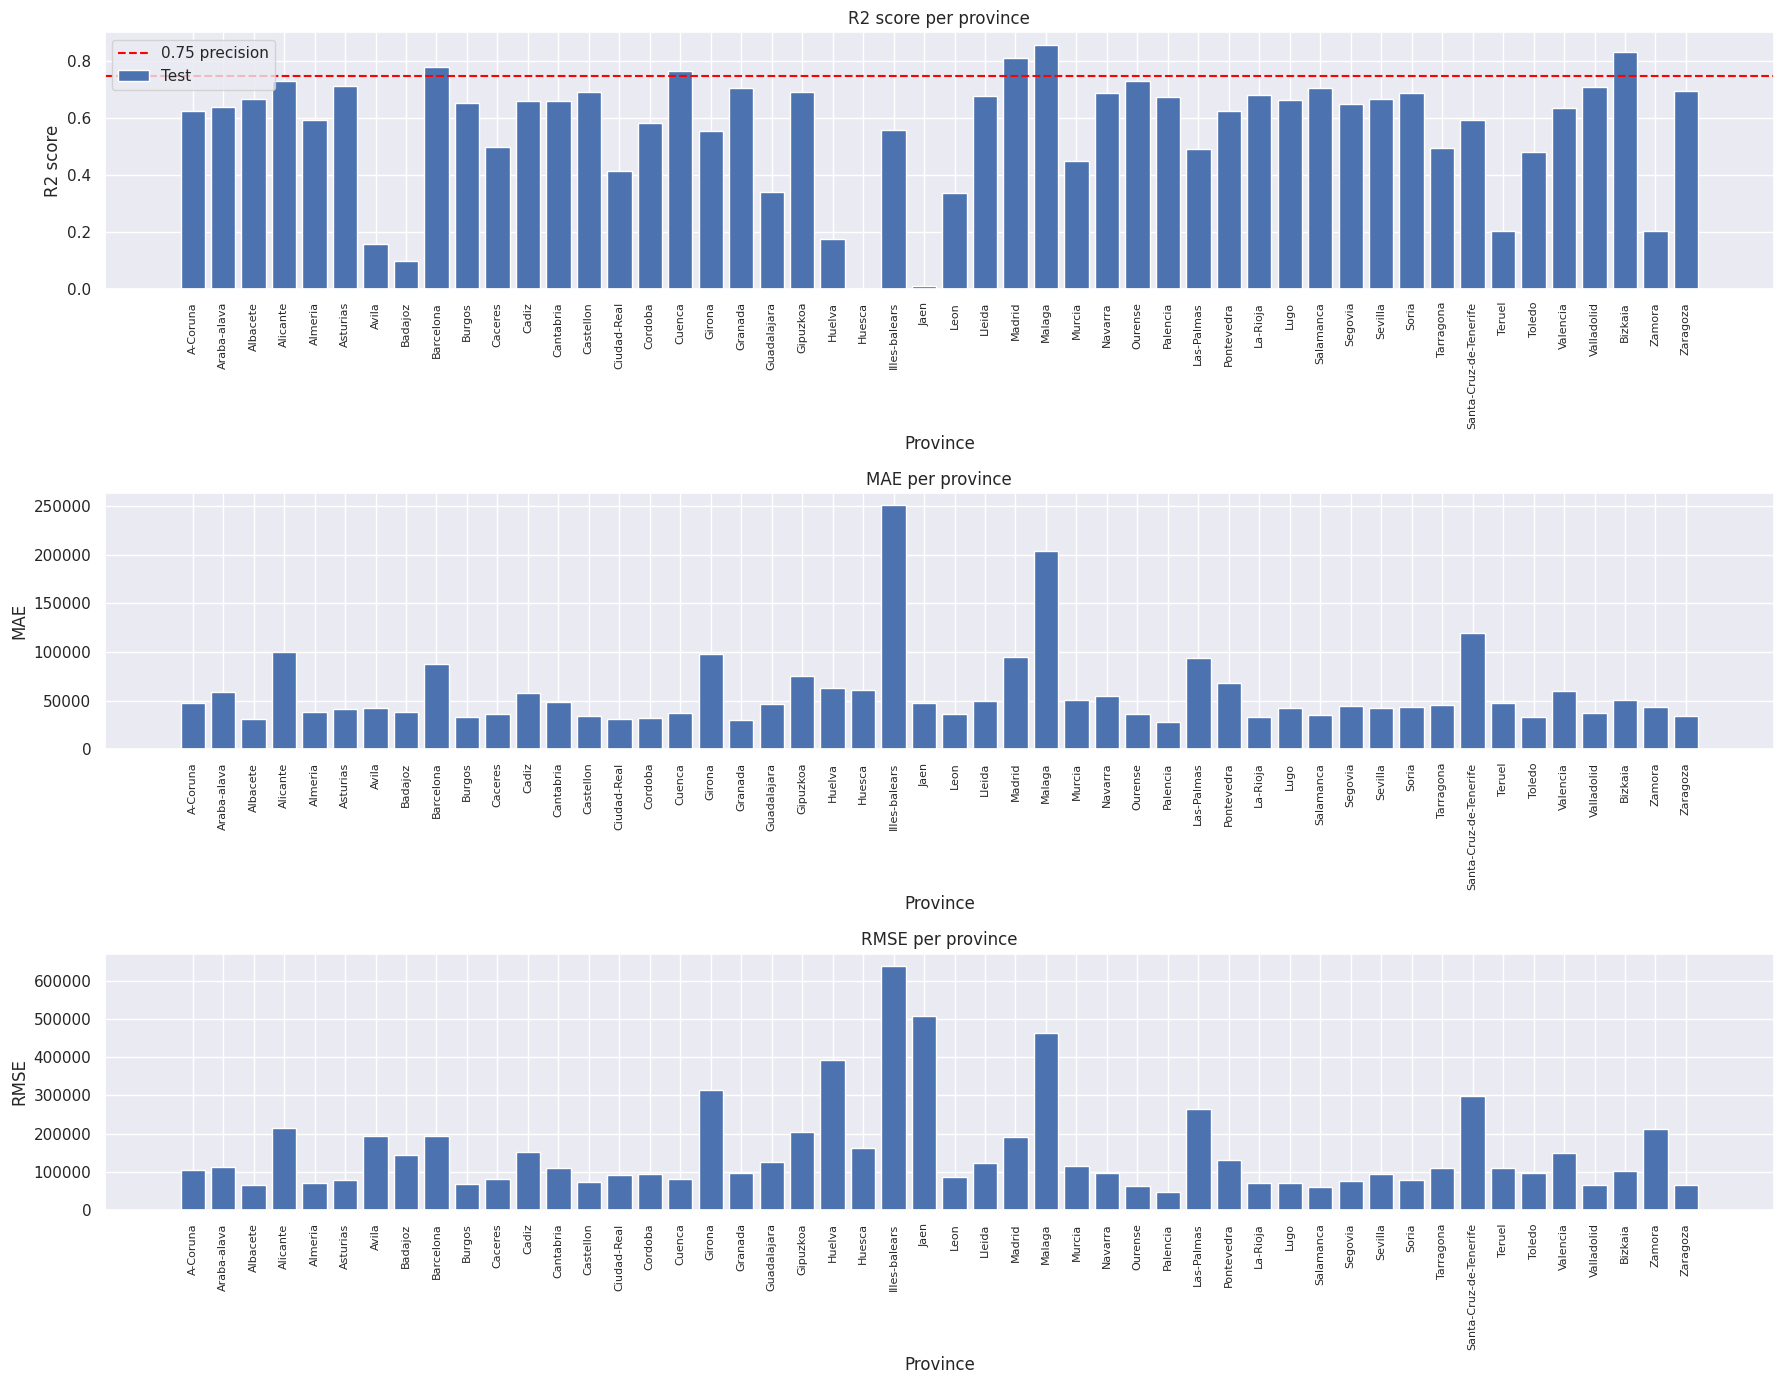

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

#Spain = pd.read_csv('Spain_filled.csv')
provinces = Spain['Province'].unique()

train_r2_values = []
val_r2_values = []
test_r2_values = []

train_mae_values = []
val_mae_values = []
test_mae_values = []

train_rmse_values = []
val_rmse_values = []
test_rmse_values = []


for province in provinces:
    province_data = Spain[Spain['Province'] == province]

    # Convert bool columns to int
    bool_columns = ["Elevator", "Parking", "Swimming_pool"]
    province_data[bool_columns] = province_data[bool_columns].astype(int)

    # Set price as the variable we are looking for
    X = province_data.drop(["Price"], axis=1)
    y = province_data["Price"]

    # Remove irrelevant variables
    X = X.drop(["Link", "Title", "Description", "Antiquity", "Orientation", "Heating", "Hot water", "Condition state", "Floor.1", "Furnished", "Ubication"], axis=1)

    # Perform one-hot encoding
    categorical_columns = ["Province", "Type", "Emitions", "Consumption", "City"]
    X = pd.get_dummies(X, columns=categorical_columns)

    # Split the data into train, validation, and test sets. 70% training, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Train model
    #rf_model = XGBRegressor()
    rf_model = RandomForestRegressor()
    rf_model.fit(X_train, y_train)

# Evaluate performance on train data
    y_train_pred = rf_model.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)

    # Evaluate performance on validation data
    y_val_pred = rf_model.predict(X_val)
    val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
    val_r2 = r2_score(y_val, y_val_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    # Evaluate performance on test data
    y_test_pred = rf_model.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_r2 = r2_score(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # Add the metrics to the respective arrays
    train_r2_values.append(train_r2)
    val_r2_values.append(val_r2)
    test_r2_values.append(test_r2)

    train_mae_values.append(train_mae)
    val_mae_values.append(val_mae)
    test_mae_values.append(test_mae)

    train_rmse_values.append(train_rmse)
    val_rmse_values.append(val_rmse)
    test_rmse_values.append(test_rmse)

    print("Province             :", province)
    print("Train RMSE           :", train_rmse)
    print("Validation RMSE      :", val_rmse)
    print("Test RMSE            :", test_rmse)
    print("Train R-squared      :", train_r2)
    print("Validation R-squared :", val_r2)
    print("Test R-squared       :", test_r2)
    print()

# Calculate average metrics
avg_train_r2 = sum(train_r2_values) / len(train_r2_values)
avg_val_r2 = sum(val_r2_values) / len(val_r2_values)
avg_test_r2 = sum(test_r2_values) / len(test_r2_values)

avg_train_mae = sum(train_mae_values) / len(train_mae_values)
avg_val_mae = sum(val_mae_values) / len(val_mae_values)
avg_test_mae = sum(test_mae_values) / len(test_mae_values)

avg_train_rmse = sum(train_rmse_values) / len(train_rmse_values)
avg_val_rmse = sum(val_rmse_values) / len(val_rmse_values)
avg_test_rmse = sum(test_rmse_values) / len(test_rmse_values)

print("Average Train R2 score     :", avg_train_r2)
print("Average Validation R2 score:", avg_val_r2)
print("Average Test R2 score      :", avg_test_r2)

print("Average Train MAE          :", avg_train_mae)
print("Average Validation MAE     :", avg_val_mae)
print("Average Test MAE           :", avg_test_mae)

print("Average Train RMSE         :", avg_train_rmse)
print("Average Validation RMSE    :", avg_val_rmse)
print("Average Test RMSE          :", avg_test_rmse)


# Create the graphs
plt.figure(figsize=(18, 14))

# R2 score
plt.subplot(3, 1, 1)
#plt.bar(provinces, np.maximum(0, train_r2_values), label='Train')
#plt.bar(provinces, np.maximum(0, val_r2_values), label='Validation')
plt.bar(provinces, np.maximum(0, test_r2_values), label='Test')
plt.xlabel('Province')
plt.ylabel('R2 score')
plt.title('R2 score per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)
desired_r2 = 0.75  # Desired reference value
plt.axhline(desired_r2, color='red', linestyle='--', label='0.75 precision')
plt.legend()

# MAE
plt.subplot(3, 1, 2)
#plt.bar(provinces, np.maximum(0, train_mae_values), label='Train')
#plt.bar(provinces, np.maximum(0, val_mae_values), label='Validation')
plt.bar(provinces, np.maximum(0, test_mae_values), label='Test')
plt.xlabel('Province')
plt.ylabel('MAE')
plt.title('MAE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)

# RMSE
plt.subplot(3, 1, 3)
#plt.bar(provinces, np.maximum(0, train_rmse_values), label='Train')
#plt.bar(provinces, np.maximum(0, val_rmse_values), label='Validation')
plt.bar(provinces, np.maximum(0, test_rmse_values), label='Test')
plt.xlabel('Province')
plt.ylabel('RMSE')
plt.title('RMSE per province')
plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()


In [99]:
import pandas as pd
import numpy as np
import joblib

# Define the new house data
new_house_data = {
    'Province': ['Alicante'],
    'Price change': [1002344000],
    'Rooms': [3],
    'Bathrooms': [1],
    'Squares': [100],
    'Floor': [1],
    'Type': ['Piso'],
    'Emitions': ['F'],
    'Consumption': ['A'],
    'Parking': [0],
    'Elevator': [0],
    'Swimming_pool': [1],
    'AntiquityMidpoint': [100],
}

# Create a DataFrame from the new house data
new_house_df = pd.DataFrame(new_house_data)

# Convert boolean columns to int
bool_columns = ["Elevator", "Parking", "Swimming_pool"]
new_house_df[bool_columns] = new_house_df[bool_columns].astype(int)

# Perform one-hot encoding
categorical_columns = ["Province", "Type", "Emitions", "Consumption"]
new_house_encoded = pd.get_dummies(new_house_df, columns=categorical_columns)

# Load the feature names used during training
feature_names_path = 'price_prediction_spain_feature_names.pkl'
feature_names = joblib.load(feature_names_path)

# Reorder columns to match the training data
new_house_encoded = new_house_encoded.reindex(columns=feature_names, fill_value=0)

# Load the trained model and scaler
model_path = 'price_prediction_spain_model.pkl'
scaler_path = 'price_prediction_spain_scaler.pkl'

rf_model = joblib.load(model_path)
scaler = joblib.load(scaler_path)

# Scale the new house data
new_house_scaled = scaler.transform(new_house_encoded)

# Predict the price for the new house
predicted_price = rf_model.predict(new_house_scaled)

# Perform predictions on the test data (assuming you have y_test)
#X_test_scaled = scaler.transform(X_test)
#y_test_pred = rf_model.predict(X_test_scaled)
#test_mae = np.mean(np.abs(y_test - y_test_pred))

# Calculate the lower and upper bounds based on the MAE
lower_bound = predicted_price - test_mae
upper_bound = predicted_price + test_mae

# Print the results
print("Predicted Price:", predicted_price[0])
print("Lower Bound:", lower_bound[0])
print("Upper Bound:", upper_bound[0])
print("Test MAE:", test_mae)


Predicted Price: 325459.7
Lower Bound: 291132.6
Upper Bound: 359786.78
Test MAE: 34327.103300360104


# Concrete case study, Alicante province


In [100]:
Spain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328462 entries, 0 to 328461
Data columns (total 26 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Link               328462 non-null  object 
 1   Title              328461 non-null  object 
 2   Price              328462 non-null  float64
 3   Price change       328462 non-null  float64
 4   Rooms              328462 non-null  float64
 5   Bathrooms          328462 non-null  float64
 6   Squares            328462 non-null  float64
 7   Floor              328462 non-null  float64
 8   Description        322714 non-null  object 
 9   Type               328462 non-null  object 
 10  Antiquity          328462 non-null  object 
 11  Orientation        328462 non-null  object 
 12  Heating            328462 non-null  object 
 13  Hot water          328462 non-null  object 
 14  Condition state    328462 non-null  object 
 15  Floor.1            328462 non-null  object 
 16  El

In [101]:
#Madrid 9226 #Alicante 5732
prov_to_analyze = 'Alicante'
prov = Spain[Spain['Province'] == prov_to_analyze]
prov.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5732 entries, 17421 to 23152
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Link               5732 non-null   object 
 1   Title              5732 non-null   object 
 2   Price              5732 non-null   float64
 3   Price change       5732 non-null   float64
 4   Rooms              5732 non-null   float64
 5   Bathrooms          5732 non-null   float64
 6   Squares            5732 non-null   float64
 7   Floor              5732 non-null   float64
 8   Description        5709 non-null   object 
 9   Type               5732 non-null   object 
 10  Antiquity          5732 non-null   object 
 11  Orientation        5732 non-null   object 
 12  Heating            5732 non-null   object 
 13  Hot water          5732 non-null   object 
 14  Condition state    5732 non-null   object 
 15  Floor.1            5732 non-null   object 
 16  Elevator           

In [102]:
print("The mean price of", prov_to_analyze ,"is:" , prov['Price'].mean())
print("The mean price of Spain is:" , Spain['Price'].mean())
print(prov_to_analyze , "is",(prov['Price'].mean()/Spain['Price'].mean())*100-100, "% more expensive than the average of Spain")
print("The median price of", prov_to_analyze ,"is:" , prov['Price'].median())
print("The median price of Spain is:" , Spain['Price'].median())
print(prov_to_analyze , "is",(prov['Price'].median()/Spain['Price'].median())*100-100, "% more expensive than the average of Spain")
print()

print("The mean squares of", prov_to_analyze ,"is:" , prov['Squares'].mean())
print("The mean squares of Spain is:" , Spain['Squares'].mean())
print(prov_to_analyze , "is",(prov['Squares'].mean()/Spain['Squares'].mean())*100-100, "% bigger in average than Spain")
print("The median squares of", prov_to_analyze ,"is:" , prov['Squares'].median())
print("The median squares of Spain is:" , Spain['Squares'].median())
print(prov_to_analyze , "is",(prov['Squares'].median()/Spain['Squares'].median())*100-100, "% bigger in median than Spain")
print()

print("The mean percentage of Swimming pools in", prov_to_analyze ,"is:" , prov['Swimming_pool'].mean())
print("The mean percentage of Swimming pools in Spain is:" , Spain['Swimming_pool'].mean())
print(prov_to_analyze , "is",(prov['Swimming_pool'].mean()/Spain['Swimming_pool'].mean())*100-100, "% more in average than Spain")
print()


The mean price of Alicante is: 328946.86793440336
The mean price of Spain is: 231750.13577521904
Alicante is 41.94031292972281 % more expensive than the average of Spain
The median price of Alicante is: 199000.0
The median price of Spain is: 145000.0
Alicante is 37.241379310344826 % more expensive than the average of Spain

The mean squares of Alicante is: 164.1221214235869
The mean squares of Spain is: 163.43055817720162
Alicante is 0.42315418493244294 % bigger in average than Spain
The median squares of Alicante is: 115.0
The median squares of Spain is: 108.0
Alicante is 6.481481481481495 % bigger in median than Spain

The mean percentage of Swimming pools in Alicante is: 0.5157013258897418
The mean percentage of Swimming pools in Spain is: 0.19150160444739422
Alicante is 169.2934753094488 % more in average than Spain



In [103]:
df_filtered = Spain.copy()
types_to_exclude = ['Casa o chalet', 'Casa adosada', 'Finca rústica', 'Planta baja', 'N/A type']
df_filtered = df_filtered[~df_filtered['Type'].isin(types_to_exclude)]


print(df_filtered['Type'].unique())

average_floor = df_filtered['Floor'].mean().round(2)
print("Average Floor in Spain: ", average_floor)

['Piso' 'Apartamento' 'Dúplex' 'Ático' 'Loft' 'Estudio']
Average Floor in Spain:  2.46


In [104]:
# Get the list of provinces in the dataset
provinces = df_filtered['Province'].unique()

# Create a list to store the results
results = []

# Iterate over each province and calculate the average floor height
for province in provinces:
    province_df = df_filtered[df_filtered['Province'] == province]
    average_floor = province_df['Floor'].mean().round(2)
    results.append((province, average_floor))

# Sort the results
results.sort(key=lambda x: x[1], reverse = True)

# Print the sorted results
for province, average_floor in results:
    print("Average Floor in", province, "Province:", average_floor)

Average Floor in Asturias Province: 3.02
Average Floor in Araba-alava Province: 2.92
Average Floor in Castellon Province: 2.92
Average Floor in Ourense Province: 2.92
Average Floor in Valencia Province: 2.91
Average Floor in Soria Province: 2.9
Average Floor in A-Coruna Province: 2.87
Average Floor in Alicante Province: 2.86
Average Floor in Bizkaia Province: 2.84
Average Floor in Burgos Province: 2.82
Average Floor in Pontevedra Province: 2.8
Average Floor in Zaragoza Province: 2.79
Average Floor in Albacete Province: 2.77
Average Floor in Lugo Province: 2.76
Average Floor in Valladolid Province: 2.69
Average Floor in Zamora Province: 2.63
Average Floor in Navarra Province: 2.62
Average Floor in Lleida Province: 2.59
Average Floor in Madrid Province: 2.58
Average Floor in Leon Province: 2.57
Average Floor in Palencia Province: 2.56
Average Floor in Gipuzkoa Province: 2.54
Average Floor in Barcelona Province: 2.52
Average Floor in Caceres Province: 2.51
Average Floor in La-Rioja Provin